# Survey C Data Exploration
Initial analyisis and visualization of the Adaptive Capacity Survey Pilot (Survey C)

# Exploring Adaptive Capacity

In [145]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from zipfile import ZipFile
import seaborn as sns
import os
import math

sns.set_theme()

In [146]:
# unzipping survey tables

# specifying location of .zip and extraction location
sur_C_path="/home/rthoms/ocean_dep/sur_C/raw_data/sur_C_27072023.zip"
sur_C_raw="/home/rthoms/ocean_dep/sur_C/raw_data/sur_C_raw"

# loading the .zip and creating a zip object
with ZipFile(sur_C_path, 'r') as zObject:

	# Extracting all the members of the zip
	# into a the specified location.
	zObject.extractall(
		path=sur_C_raw)

In [147]:
# specifiying location of raw data
# main table
acs_raw = os.path.join(sur_C_raw, "Adapative_Capacity_Survey_0.csv")
df_main = pd.read_csv(acs_raw)
# practice repeat table
prac_raw = os.path.join(sur_C_raw, "practice_table_1.csv")
df_prac  = pd.read_csv(prac_raw)
# boat repeat table
boat_raw = os.path.join(sur_C_raw, "boat_table_2.csv")
df_prac  = pd.read_csv(prac_raw)

In [148]:
# drop unesessary data
df_prac = df_prac.drop(['CreationDate', 'Creator','Editor', 'EditDate'], axis=1)

In [149]:
# order ccp column
df_main.ccp = pd.Categorical(df_main.ccp,categories=['ilha', 'nhamua', 'josina_machel', 'chamane', 'mucucune',
                                                    'madava', 'kuguana', 'nhamaxaxa', 'sahane','nguja','morrumbene'],ordered=True)

In [150]:
# rename survey123 id column to ParentGlobal id to merge repeat table with main table
df_main.rename(columns={'globalid':'ParentGlobalID'}, inplace=True)
len(df_main)

96

In [151]:
# merge the practice repeat table with the main table
df_wk = pd.merge(df_main,df_prac,on='ParentGlobalID', how='left')
len(df_wk) #note that there are 6 repeated surveys - this corresponds to fishers who practice with more than one gear

103

In [152]:
# load units conversion sheet 
units_cnv_path ="/home/rthoms/ocean_dep/sur_B/clean_up/units.csv"
units_cnv = pd.read_csv(units_cnv_path)

# convert to dict 
unit_dict= pd.Series(units_cnv.weight_kg.values,index=units_cnv.unit).to_dict()

In [153]:
# categorize the practive (glean, shrimp_net, vs capture fish)
def cat_pract(pract):
    if pract == 'glean' or pract == 'shrimp_net':
        return pract
    else:
        return 'fish'
    
df_wk['pract_cat'] = df_wk.apply(lambda row : cat_pract(row['gear']), axis = 1)

In [154]:
# Drop any duplicates in practice categories (i.e. a fisher who fishes using 2 gear types)
df_wk = df_wk.drop_duplicates(
    subset = ['ParentGlobalID', 'pract_cat'],
    keep = 'first').reset_index(drop = True)
len(df_wk) # note there are now only 3 repeated survey ids

99

In [155]:
# function to fill other column
def fill_other(col, col_other):
    if col == "other":
        return col_other
    else:
        return col

# fill unit_other with values 
df_wk['unit_final']= df_wk.apply(lambda row: fill_other(row['unit'],row['units_other']), axis=1 ) 

In [156]:
# list all columns to guide clean up
df_main.columns

Index(['objectid', 'ParentGlobalID', 'id', 'date', 'ccp', 'focal_resources',
       'gender', 'age', 'birth_place', 'mar_status', 'ed_level', 'house_head',
       'glean', 'electricity', 'fridge_freezer', 'fridge_freezer_num', 'water',
       'matress', 'matress_num', 'mobile_phone', 'mobile_phone_num',
       'smart_phone', 'smart_phone_num', 'fan', 'fan_num', 'tv', 'tv_num',
       'radio', 'radio_num', 'stove', 'stove_num', 'transport',
       'transport_num', 'floor', 'floor_other', 'wall', 'wall_other', 'roof',
       'roof_other', 'access_credit_loans', 'community_participation',
       'ccp_member', 'ccp_participation', 'decision_making_manag',
       'decision_making_fish', 'change_seagrass', 'direction_change_seagrass',
       'causes_change_seagrass', 'change_fish', 'direction_change_resources',
       'causes_change_resources', 'link_seagrass_resources',
       'capacity_change_practice', 'capacity_change_livelihood',
       'capacity_organize', 'local_knowledge', 'agency_ch

In [157]:
df_main.birth_place.unique()

array(['community', 'coastal_area', 'country', 'district'], dtype=object)

### Fishing counsels surveyed

The `ccp` column records the Community Fishing Council (Conselho Communitario da Pesca, CCP) where the survey was recorded. Survey C was carried out in a total of 12 CCPs. The target sample size for each CCP was 8 respondents. However due to weather and time constraints, less than 8 respondents were surveyed in some communities. On the other hand, due to abundance of time and respondents, in other communities, more than 8 respondents were surveyed.

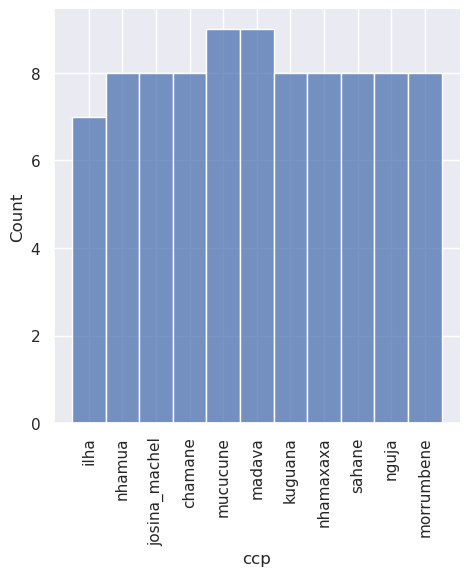

In [158]:
# examine the ccp column 

# descriptive statistics summary
df_wk['ccp'].describe()

df_ccp= df_wk.groupby(['ccp'])['ccp'].count()

# SORT DATA 
ax=sns.displot(data=df_wk.sort_values('ccp'), stat="count", x="ccp")
ax.set_xticklabels(rotation=90)

### Genders surveyed

The `gender` column describes the sex of the respondent.

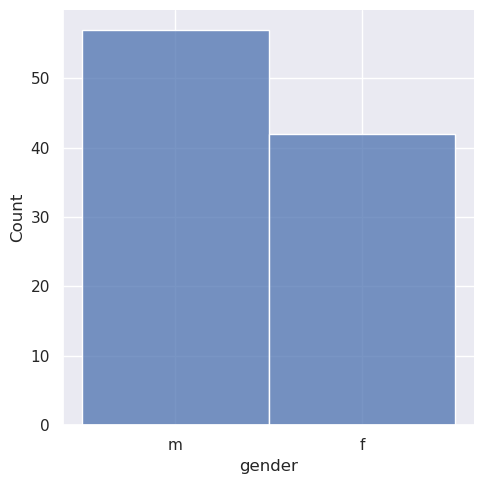

In [159]:
ax=sns.displot(data=df_wk.sort_values('ccp'), stat="count", x="gender")

#### Gender by community surveyed
Although surveyers had a goal of surveying a balanced number of men and women in each community, this was not acheived in all communities due to the fishers that could be organized by the counsel leadership. Namely Chamane, Morrumebene, and Nguja many more men were surveyed then wommen.

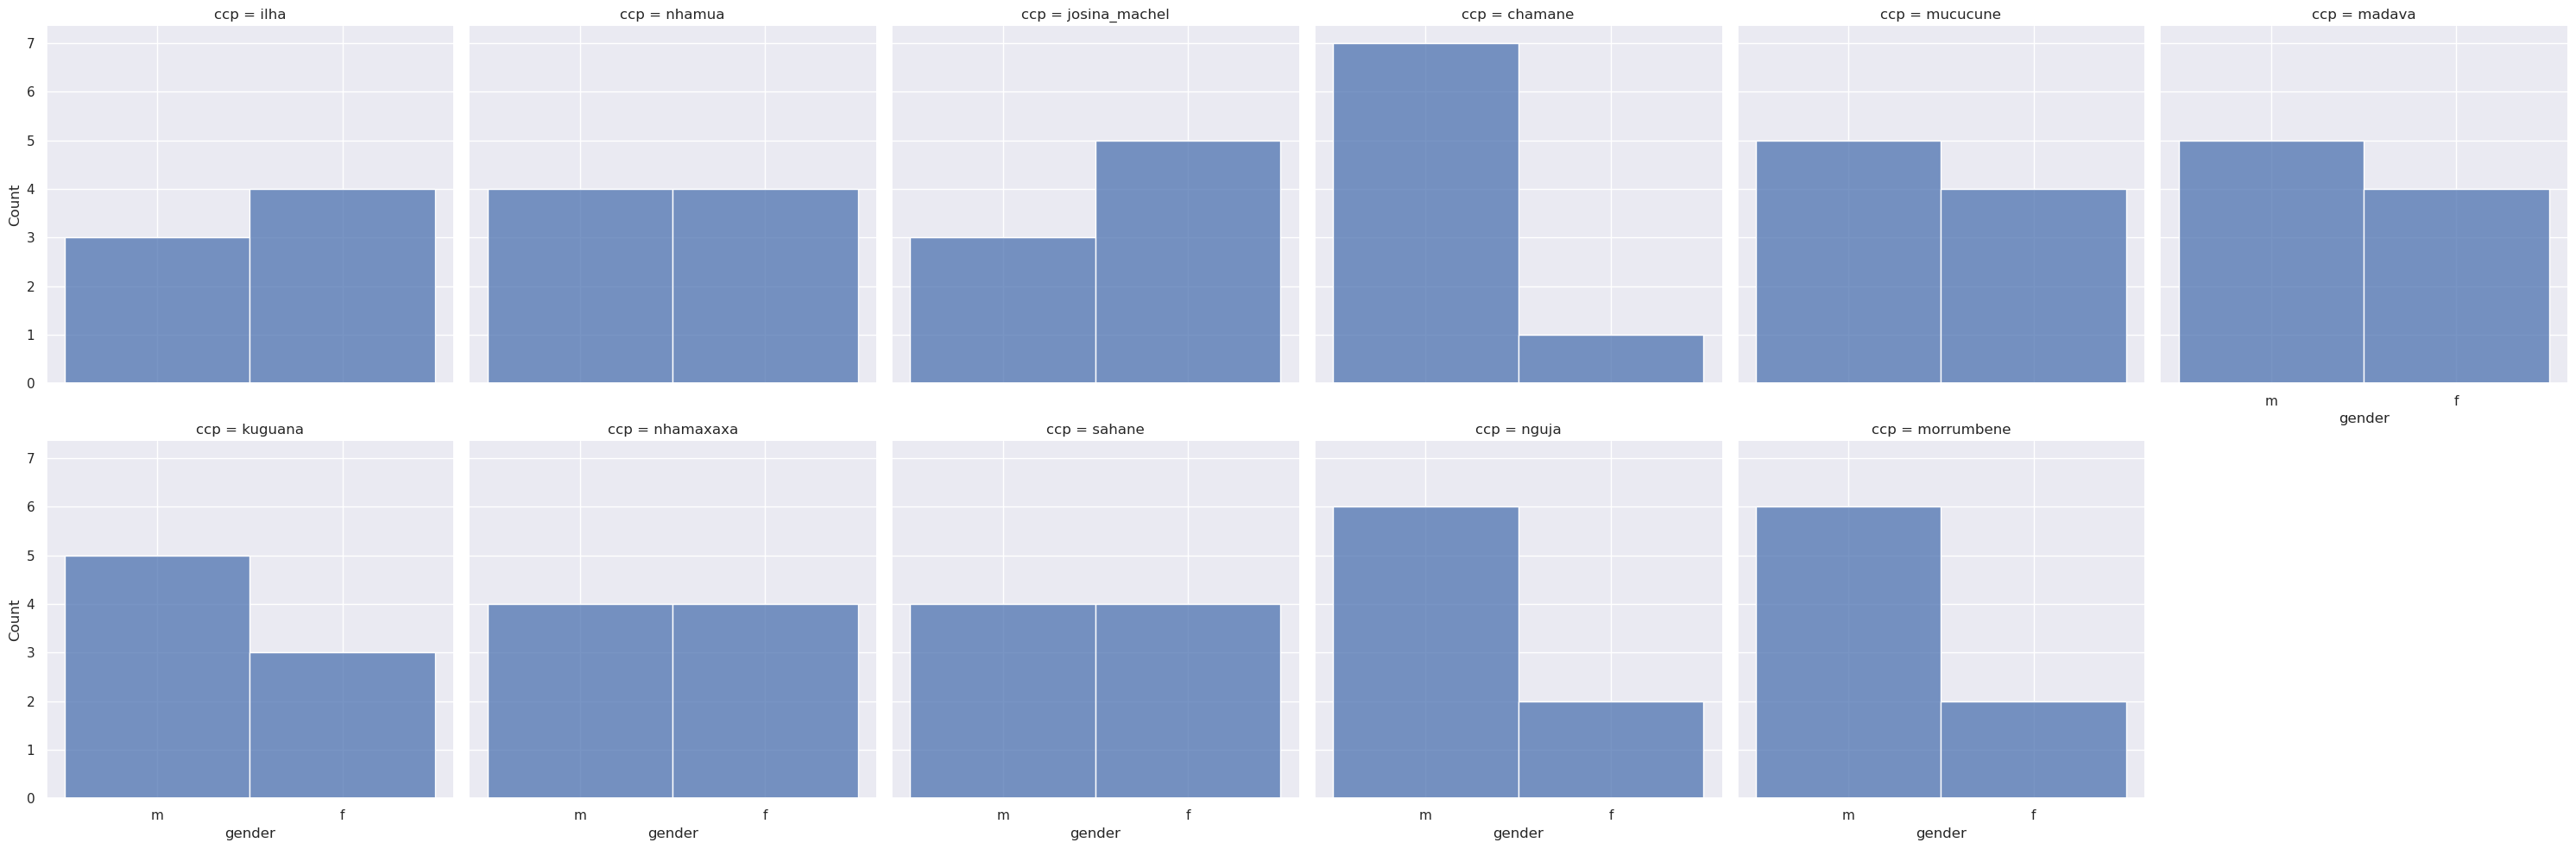

In [160]:
ax=sns.displot(data=df_wk.sort_values('ccp'), stat="count", x="gender", col='ccp', col_wrap=6)

### Birth place

The `birth_place` column shows the most relevant choice for where the respondent is from, either in the community where the survey is taking place, another coastal area, the ineterior of the district, or another part of the interior of the country.

In [161]:
df_wk['birth_place'].unique()

array(['community', 'coastal_area', 'country', 'district'], dtype=object)

In [162]:
df_wk['birth_place'] = df_wk['birth_place'].str.replace('coastal_area','other coastal area')
df_wk['birth_place'] = df_wk['birth_place'].str.replace('district','district interior')
df_wk.birth_place = pd.Categorical(df_wk.birth_place,categories=['community', 'other coastal area', 'district interior', 'country'],ordered=True)

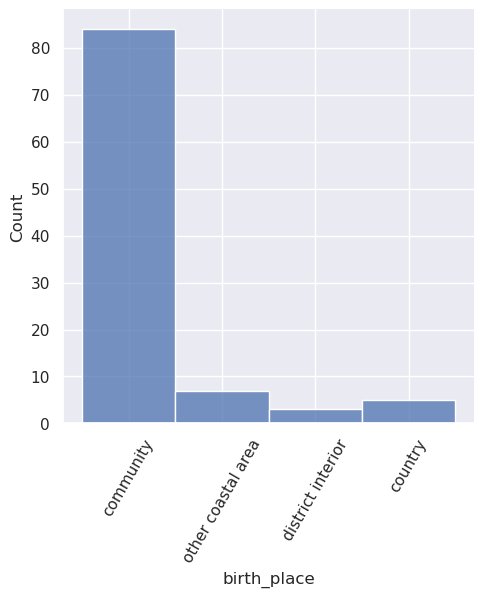

In [163]:
ax=sns.displot(data=df_wk, stat="count", x="birth_place")
ax.set_xticklabels(rotation=60)

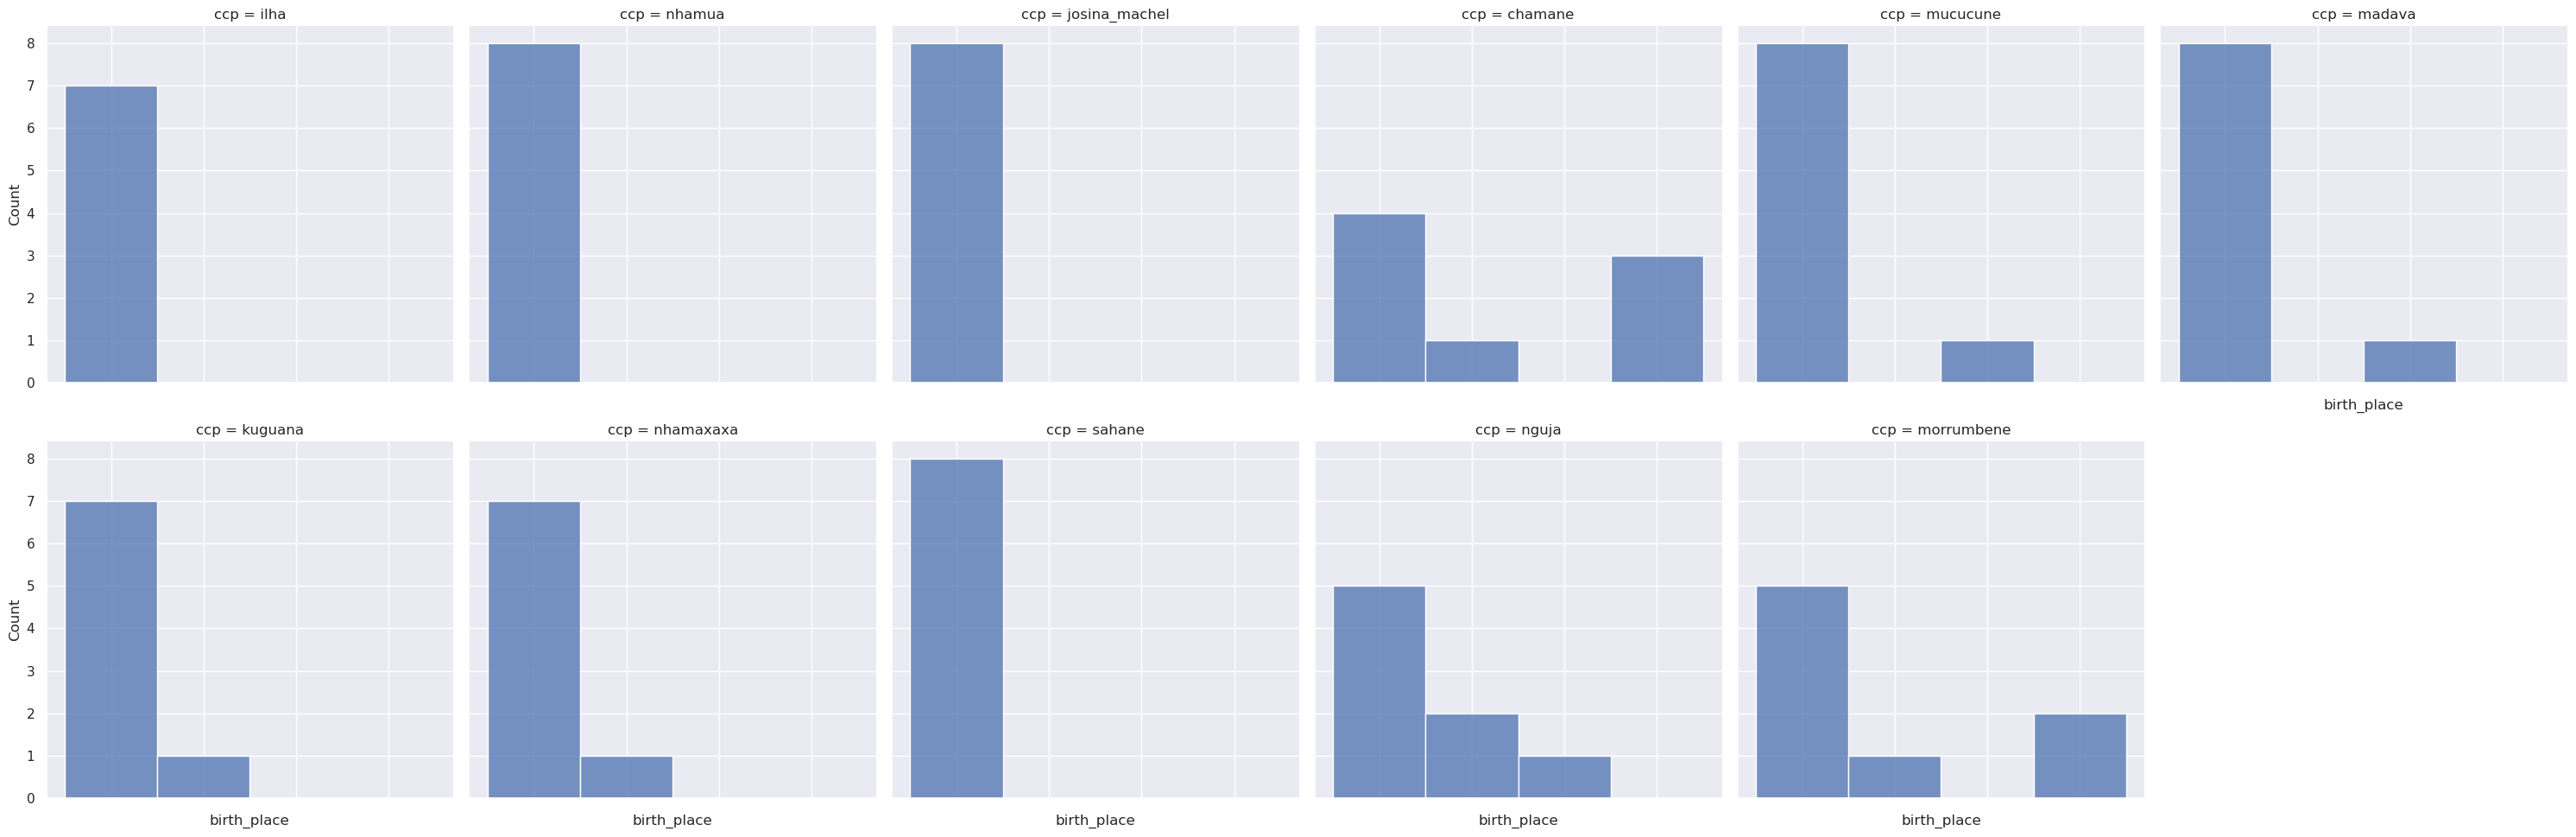

In [164]:
ax=sns.displot(data=df_wk, stat="count", x="birth_place", col='ccp', col_wrap=6)

ax.set_xticklabels(rotation=60)

### Maritial Status
Records whether the respondent is single, married, or widdowed

In [165]:
# explore where data have not been entered 
nr= df_wk[df_wk['mar_status']=='NR']
nr # for both entries (09032023NHCHC04 & 10032023SAHC06) responses were not recorded in the field

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,gear_number,practiced,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final
19,20,24e21755-2097-41d2-aef1-3d9966b94b07,09032023NHCHC04,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",m,56.0,community,NR,...,1.0,1,8.0,kgs,NaN,2.0,1600.0,2.0,fish,kgs
73,71,c0a9fc2e-3c53-4638-b671-005d4bdf4e0a,10032023SAHC06,5/5/2023 10:00:00 AM,sahane,"01,50,56,60,63,69",f,NaN,community,NR,...,1.0,1,16.0,cups,NaN,3.0,320.0,2.0,shrimp_net,cups


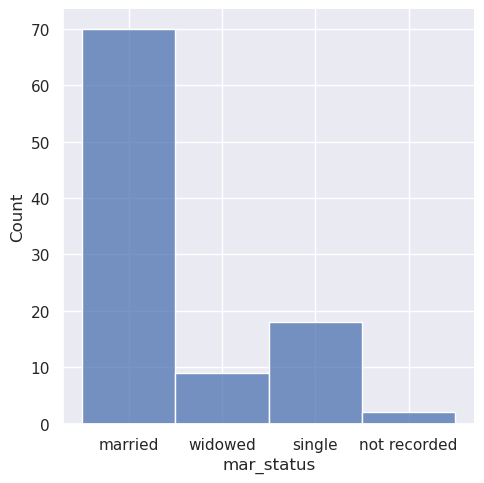

In [166]:
df_wk.mar_status = pd.Categorical(df_wk.mar_status,categories=['m', 'w', 's', 'NR'],ordered=True)
df_wk['mar_status']=df_wk['mar_status'].map({'m': 'married', 's' : 'single', 'w' : 'widowed','NR': 'not recorded'})
ax=sns.displot(data=df_wk, stat="count", x="mar_status")

Disaggregating this information by gender, we see that men surveyed have a much higher probability of being married than women, who show higher counts for single and widowed than men surveyed

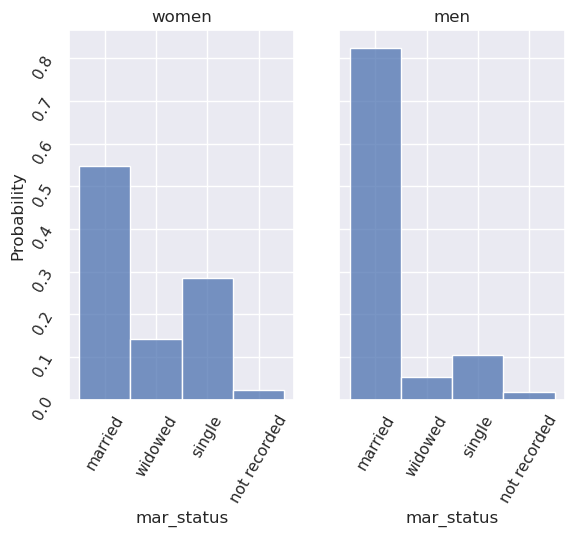

In [167]:
fig, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk[df_wk['gender']=='f'], stat="probability", x="mar_status", ax=axes[0])
axes[0].set_title('women')
sns.histplot(data=df_wk[df_wk['gender']=='m'], stat="probability", x="mar_status", ax=axes[1])
axes[1].set_title('men')
for ax in fig.axes:
    ax.tick_params(labelrotation=60)

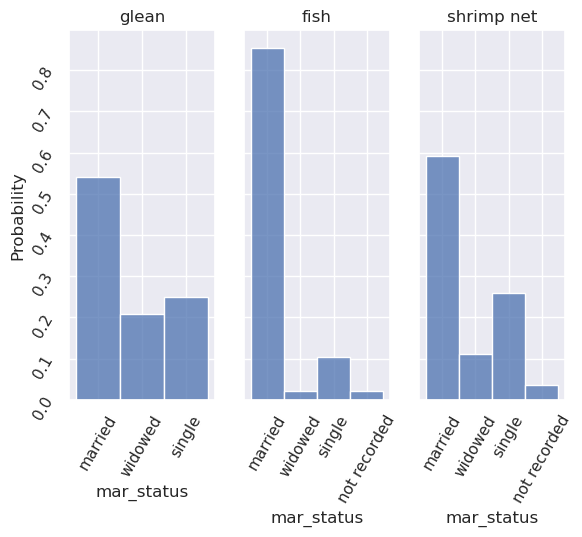

In [168]:
fig, axes = plt.subplots(1, 3, sharey=True)
sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="mar_status", ax=axes[0])
axes[0].set_title('glean')
sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="mar_status", ax=axes[1])
axes[1].set_title('fish')
sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="mar_status", ax=axes[2])
axes[2].set_title('shrimp net')
for ax in fig.axes:
    ax.tick_params(labelrotation=60)

### Education level

In [169]:
# explore where data have not been entered 
nr= df_wk[df_wk['ed_level']=='NR']
nr # for all 3 entries (03032023MADC08, 11032023KUGC07, & 10032023SAHC06) responses were not recorded in the field

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,gear_number,practiced,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final
58,56,a656481f-be46-4f2a-b83d-28a3e3af1f01,03032023MADC08,5/4/2023 10:00:00 AM,madava,"50,52,53,56,68,70,78",m,NaN,community,single,...,4.0,1,20.0,kgs,NaN,5.0,4000.0,2.0,fish,kgs
66,64,ce3ca77e-d261-445f-a3a0-f31a7418d2e6,11032023KUGC07,5/4/2023 10:00:00 AM,kuguana,"01,50,52,53,55,56,68,78",m,37.0,community,married,...,1.0,1,4.5,kgs,NaN,2.0,650.0,NaN,fish,kgs
73,71,c0a9fc2e-3c53-4638-b671-005d4bdf4e0a,10032023SAHC06,5/5/2023 10:00:00 AM,sahane,"01,50,56,60,63,69",f,NaN,community,not recorded,...,1.0,1,16.0,cups,NaN,3.0,320.0,2.0,shrimp_net,cups


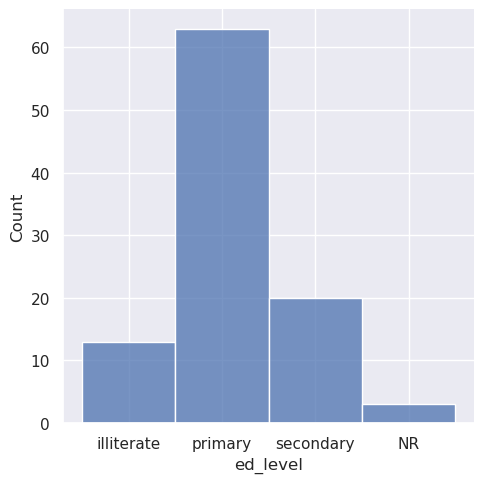

In [170]:
df_wk.ed_level = pd.Categorical(df_wk.ed_level,categories=['illiterate', 'primary', 'secondary', 'NR'],ordered=True)
ax=sns.displot(data=df_wk.sort_values("ed_level"), stat="count", x="ed_level")

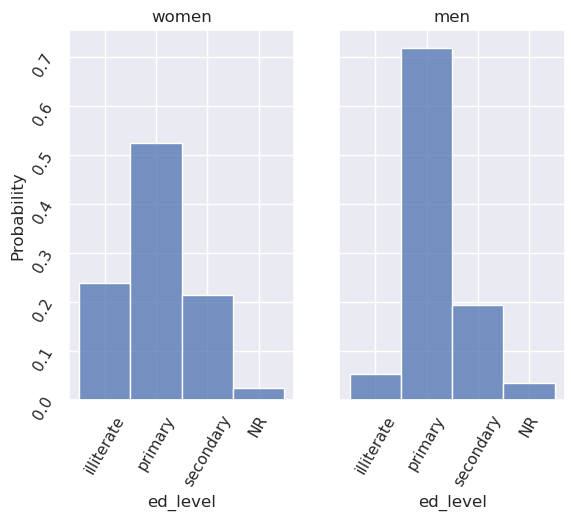

In [171]:
fig, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk[df_wk['gender']=='f'], stat="probability", x="ed_level", ax=axes[0])
axes[0].set_title('women')
sns.histplot(data=df_wk[df_wk['gender']=='m'], stat="probability", x="ed_level", ax=axes[1])
axes[1].set_title('men')
for ax in fig.axes:
    ax.tick_params(labelrotation=60)

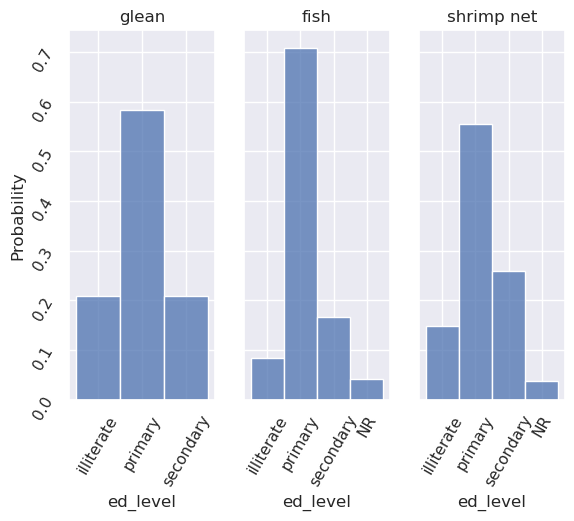

In [172]:
fig, axes = plt.subplots(1, 3, sharey=True)
sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="ed_level", ax=axes[0])
axes[0].set_title('glean')
sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="ed_level", ax=axes[1])
axes[1].set_title('fish')
sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="ed_level", ax=axes[2])
axes[2].set_title('shrimp net')
for ax in fig.axes:
    ax.tick_params(labelrotation=60)

### Head of household

In [173]:
# explore where data have not been entered 
nr = df_wk[df_wk['house_head']=='NR']
nr # for all 4 entries (09032023NHCHC04, 11032023KUGC04, 10032023SAHC04, & 10032023SAHC06) responses were not recorded in the field

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,gear_number,practiced,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final
19,20,24e21755-2097-41d2-aef1-3d9966b94b07,09032023NHCHC04,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",m,56.0,community,not recorded,...,1.0,1,8.0,kgs,NaN,2.0,1600.0,2.0,fish,kgs
63,61,48342f3b-aefd-4bc7-932f-19863d9c7742,11032023KUGC04,5/4/2023 10:00:00 AM,kuguana,"01,50,52,53,55,56,68,78",m,56.0,community,married,...,1.0,1,30.0,kgs,NaN,6.0,3000.0,12.0,fish,kgs
71,69,e3ae26a7-1743-40bb-8640-e5c5820dc2db,10032023SAHC04,5/5/2023 8:33:57 AM,sahane,"01,50,56,60,63,69",f,49.0,community,single,...,NaN,1,2.5,kgs,NaN,2.0,125.0,NaN,glean,kgs
73,71,c0a9fc2e-3c53-4638-b671-005d4bdf4e0a,10032023SAHC06,5/5/2023 10:00:00 AM,sahane,"01,50,56,60,63,69",f,NaN,community,not recorded,...,1.0,1,16.0,cups,NaN,3.0,320.0,2.0,shrimp_net,cups


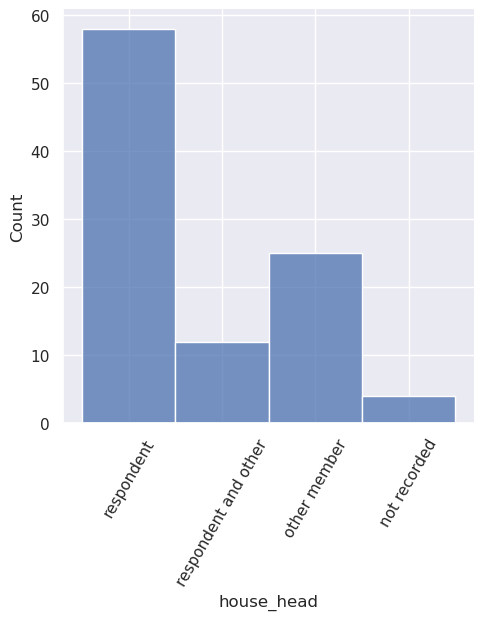

In [174]:
df_wk['house_head']=df_wk['house_head'].map({'other': 'other member', 'respondent' : 'respondent', 'respondent and other' : 'respondent and other', 'respondent_and_other' : 'respondent and other', 'NR': 'not recorded'})
df_wk.house_head = pd.Categorical(df_wk.house_head,categories=['respondent', 'respondent and other', 'other member', 'not recorded'],ordered=True)
ax=sns.displot(data=df_wk.sort_values("house_head"), stat="count", x="house_head")
ax.set_xticklabels(rotation=60)


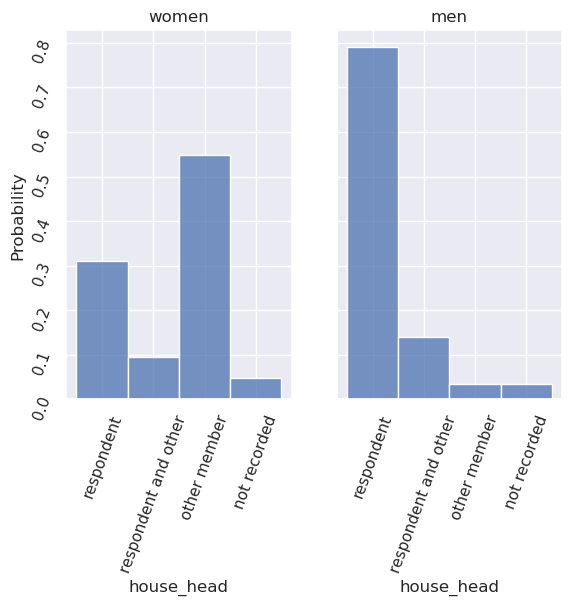

In [175]:
fig, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk[df_wk['gender']=='f'], stat="probability", x="house_head", ax=axes[0])
axes[0].set_title('women')
sns.histplot(data=df_wk[df_wk['gender']=='m'], stat="probability", x="house_head", ax=axes[1])
axes[1].set_title('men')
for ax in fig.axes:
    ax.tick_params(labelrotation=70)

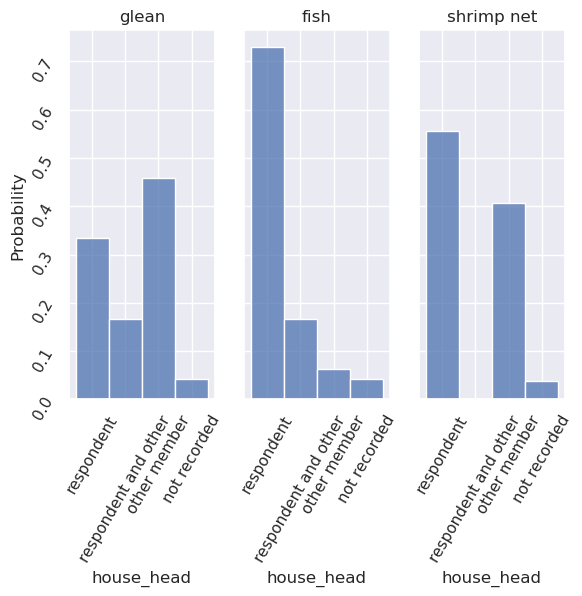

In [176]:
fig, axes = plt.subplots(1, 3, sharey=True)
sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="house_head", ax=axes[0])
axes[0].set_title('glean')
sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="house_head", ax=axes[1])
axes[1].set_title('fish')
sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="house_head", ax=axes[2])
axes[2].set_title('shrimp net')
for ax in fig.axes:
    ax.tick_params(labelrotation=60)

### Glean

In [177]:
# explore where data have not been entered 
nr = df_wk[df_wk['glean']=='NR']
nr 

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,gear_number,practiced,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final


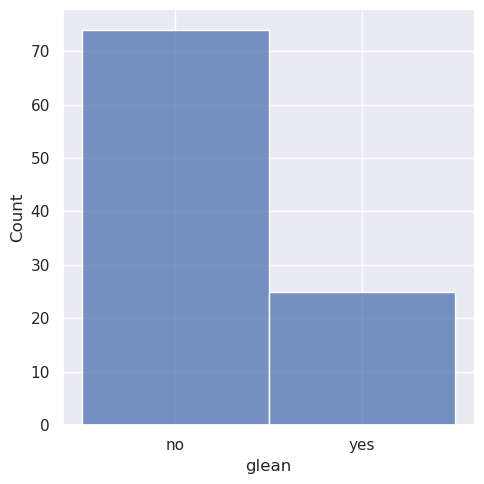

In [178]:
df_wk['glean']=df_wk['glean'].map({0: 'no', 1 : 'yes'})
ax=sns.displot(data=df_wk.sort_values("glean"), stat="count", x="glean")

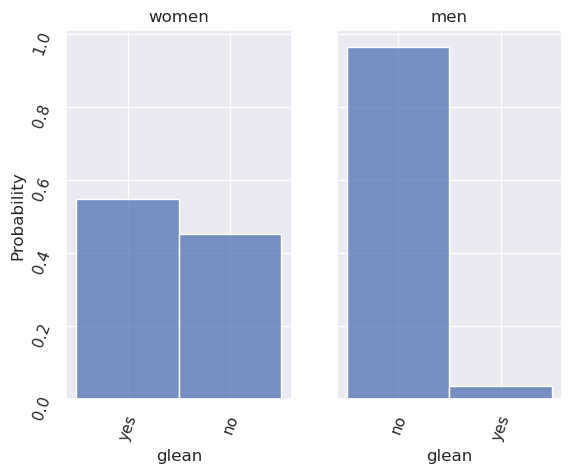

In [179]:
fig, axes = plt.subplots(1, 2, sharey=True)
sns.histplot(data=df_wk[df_wk['gender']=='f'], stat="probability", x="glean", ax=axes[0])
axes[0].set_title('women')
sns.histplot(data=df_wk[df_wk['gender']=='m'], stat="probability", x="glean", ax=axes[1])
axes[1].set_title('men')
for ax in fig.axes:
    ax.tick_params(labelrotation=70)

### Capture

#### Daily Capture

In [180]:
def cap_daily(units, quant):
    units_cv = float(unit_dict[units])
    if units_cv is not None:
        cap = quant* units_cv
    else: 
        cap = None
    return cap

df_wk['cap_daily_total'] = df_wk.apply(lambda row: cap_daily(row['unit_final'], row['quantity']), axis=1)

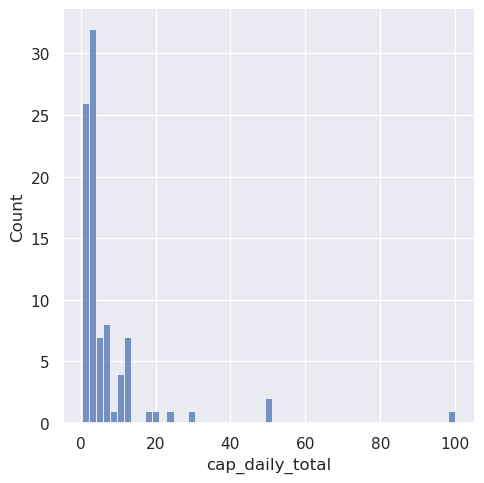

In [181]:
ax=sns.displot(data=df_wk, stat="count", x="cap_daily_total")

In [182]:
df_wk.groupby('gear')['cap_daily_total'].describe()

,count,mean,std,min,25%,50%,75%,max
gear,,,,,,,,
basket_trap,2.0,3.500000,0.707107,3.00,3.25,3.5,3.7500,4.0
diving,1.0,6.000000,NaN,6.00,6.00,6.0,6.0000,6.0
drag_net,4.0,57.500000,29.860788,30.00,45.00,50.0,62.5000,100.0
fence_trap,13.0,4.884615,2.399252,3.00,4.00,4.0,5.0000,12.0
gill_net,14.0,10.964286,6.252582,3.00,6.25,10.0,12.3750,24.0
glean,23.0,3.928261,3.729400,0.35,2.00,2.5,4.0000,12.0
hand_line,12.0,4.416667,2.429303,2.00,3.00,3.5,5.5000,10.0
shrimp_net,23.0,2.357609,1.205820,1.00,1.75,2.0,2.7125,6.0


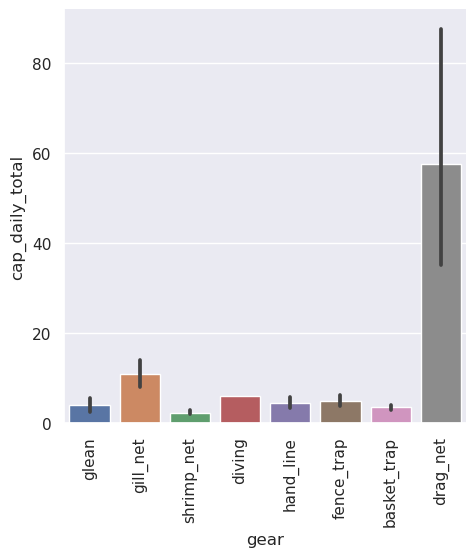

In [183]:
ax=sns.catplot(data=df_wk, x="gear", y='cap_daily_total', kind='bar')
ax.set_xticklabels(rotation=90)

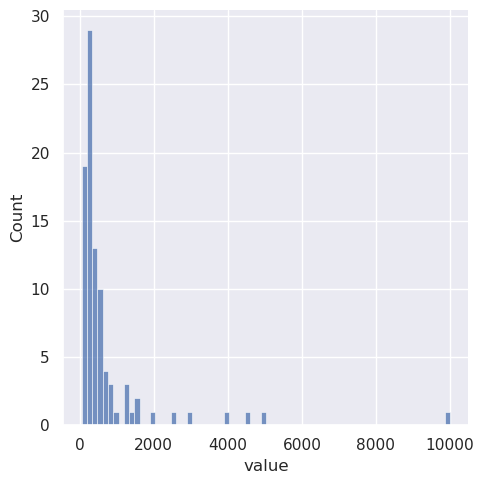

In [184]:
ax=sns.displot(data=df_wk, stat="count", x="value")

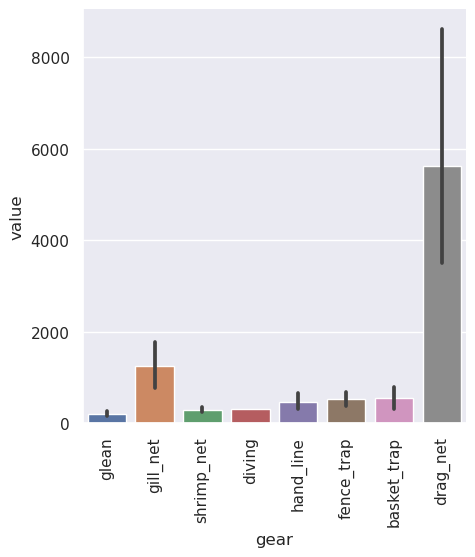

In [185]:
ax=sns.catplot(data=df_wk, x="gear", y='value', kind='bar')
ax.set_xticklabels(rotation=90)

#### Hours per day

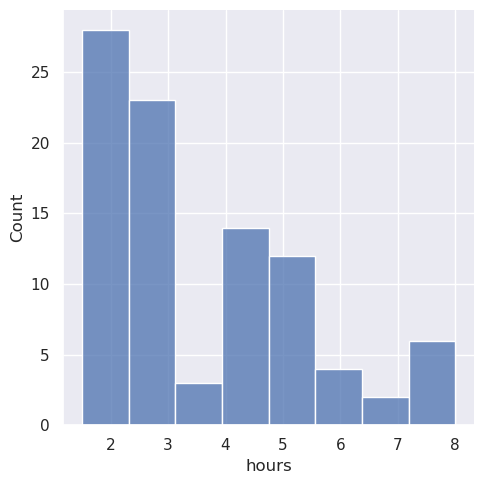

In [186]:
ax=sns.displot(data=df_wk, stat="count", x="hours")

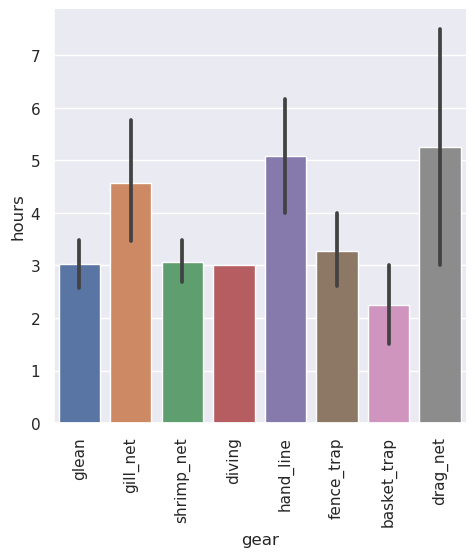

In [187]:
ax=sns.catplot(data=df_wk, x="gear", y='hours', kind='bar')
ax.set_xticklabels(rotation=90)

#### Number of crew members

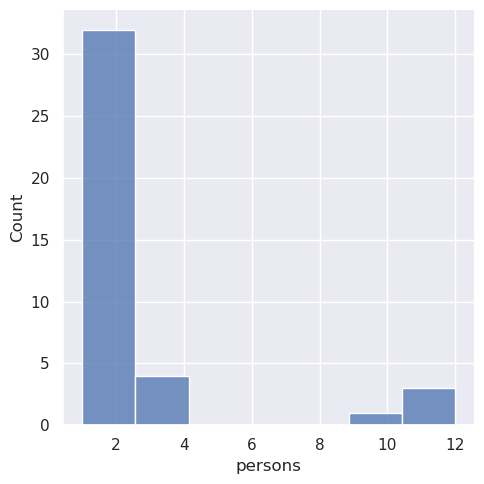

In [188]:
ax=sns.displot(data=df_wk, stat="count", x="persons")

/home/rthoms/anaconda3/envs/data_dev/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/rthoms/anaconda3/envs/data_dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/rthoms/anaconda3/envs/data_dev/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/rthoms/anaconda3/envs/data_dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/rthoms/anaconda3/envs/data_dev/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/rthoms/anaconda3/envs/data_dev/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice


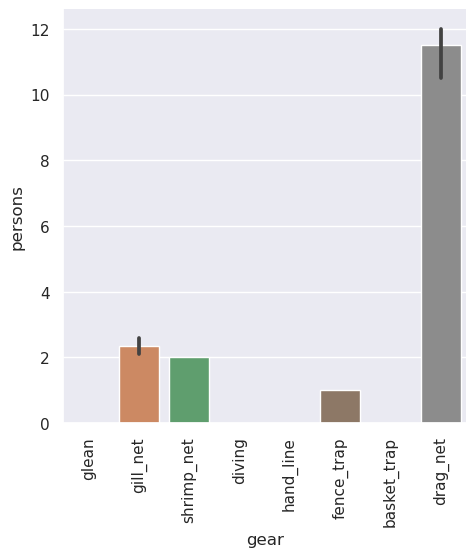

In [189]:
ax=sns.catplot(data=df_wk, x="gear", y='persons', kind='bar')
ax.set_xticklabels(rotation=90)

#### Catch per unit effort
CPUE here is definited as catch per person per hour per day

In [190]:
# function to calculate CPUE 
def cpue(cap_total, persons, hours):
    if math.isnan(persons) or persons =='':
        persons = 1
    cpue = cap_total/(persons*hours)
    return cpue

df_wk['cpue'] = df_wk.apply(lambda row: cpue(row['cap_daily_total'], row['persons'],row['hours'] ), axis=1)


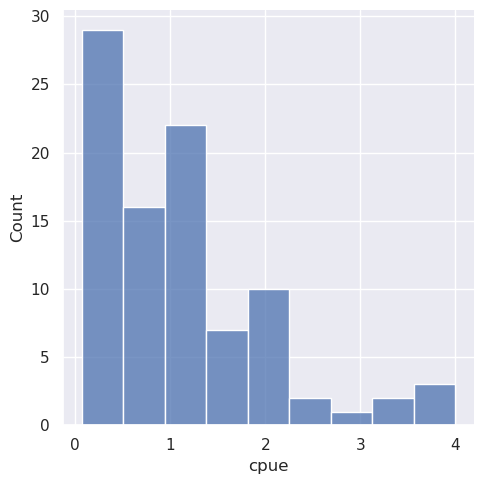

In [191]:
ax=sns.displot(data=df_wk, stat="count", x="cpue")

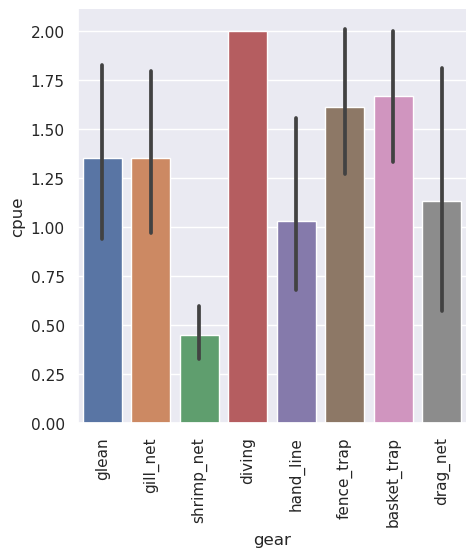

In [192]:
ax=sns.catplot(data=df_wk, x="gear", y='cpue', kind='bar')
ax.set_xticklabels(rotation=90)

#### Catch value

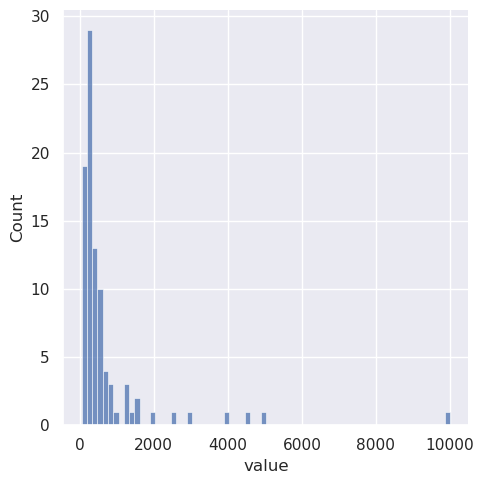

In [193]:
ax=sns.displot(data=df_wk, stat="count", x="value")

In [194]:
df_wk.groupby('gear')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
gear,,,,,,,,
basket_trap,2.0,550.000000,353.553391,300.0,425.00,550.00,675.0,800.0
diving,1.0,300.000000,NaN,300.0,300.00,300.00,300.0,300.0
drag_net,4.0,5625.000000,3037.954356,3000.0,4125.00,4750.00,6250.0,10000.0
fence_trap,13.0,519.230769,296.997798,200.0,300.00,450.00,650.0,1250.0
gill_net,14.0,1255.892857,1047.201218,200.0,500.00,1068.75,1575.0,4000.0
glean,23.0,202.608696,146.270838,50.0,100.00,150.00,275.0,500.0
hand_line,12.0,468.366667,338.470107,175.4,281.25,355.00,525.0,1400.0
shrimp_net,23.0,289.021739,136.049663,120.0,200.00,250.00,350.0,720.0


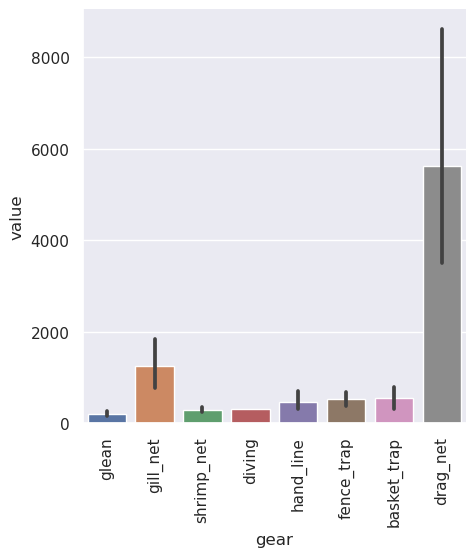

In [195]:
ax=sns.catplot(data=df_wk, x="gear", y='value', kind='bar')
ax.set_xticklabels(rotation=90)

### Acess to credits and loans

In [196]:
# explore where data have not been entered 
nr = df_wk[df_wk['access_credit_loans']=='NR']
nr 

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
38,37,93ca075b-003e-4767-a9ca-b17a08ab7ed0,01032023MARC06,5/3/2023 10:00:00 AM,NaN,"01,02,03,06,50,56,74,78",f,43.0,community,married,...,10.0,cups,NaN,3.0,250.0,2.0,shrimp_net,cups,1.75,0.291667
40,39,63246f44-bd58-4641-9197-b54e87c99965,01032023MARC08,5/3/2023 10:00:00 AM,NaN,"01,02,03,06,50,56,74,78",m,57.0,community,married,...,7.0,kgs,NaN,6.0,770.0,NaN,fish,kgs,7.00,1.166667
41,39,63246f44-bd58-4641-9197-b54e87c99965,01032023MARC08,5/3/2023 10:00:00 AM,NaN,"01,02,03,06,50,56,74,78",m,57.0,community,married,...,10.0,cups,NaN,3.0,200.0,2.0,shrimp_net,cups,1.75,0.291667


After consulting data sheets it was determined that for the 2 surveys (01032023MARC06 & 01032023MARC08) responses were not recorded in the field

In [197]:
# descriptive statistics summary
df_wk['access_credit_loans'].describe()

count       99
unique       4
top       none
freq        59
Name: access_credit_loans, dtype: object

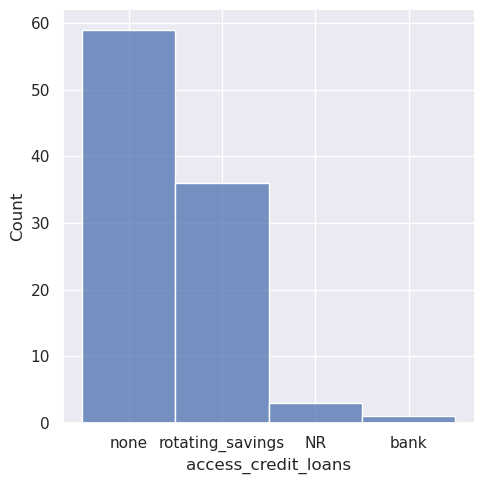

In [198]:
ax=sns.displot(data=df_wk, stat="count", x="access_credit_loans")

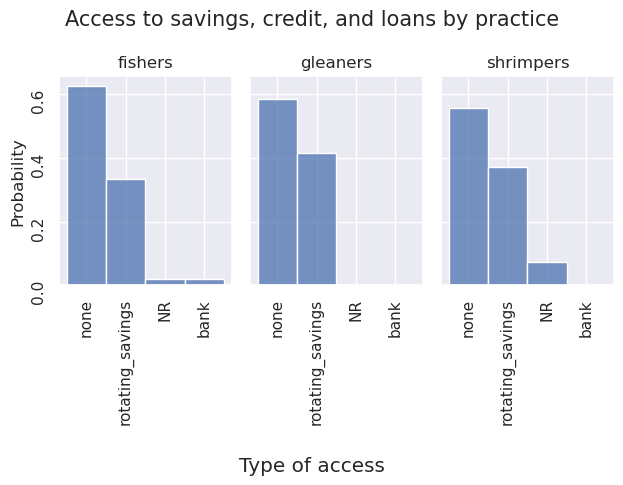

In [199]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="access_credit_loans", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="access_credit_loans", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="access_credit_loans", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Access to savings, credit, and loans by practice', fontsize=15)
fig.supxlabel('Type of access')
plt.tight_layout()

### Pariticpation in Community Organizations

In [200]:
# explore where data have not been entered 
nr = df_wk[df_wk['community_participation']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [201]:
df_wk['community_participation']=df_wk['community_participation'].map({0: 'no', 1 : 'yes'})

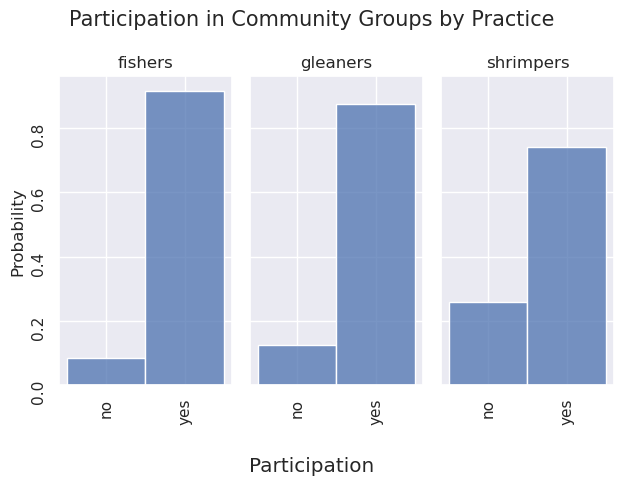

In [202]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="community_participation", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="community_participation", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="community_participation", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Participation in Community Groups by Practice', fontsize=15)
fig.supxlabel('Participation')
plt.tight_layout()

### Membership in CCPs

In [203]:
# explore where data have not been entered 
nr = df_wk[df_wk['ccp_member']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [204]:
df_wk['ccp_member']=df_wk['ccp_member'].map({0: 'non-member', 1 : 'member'})


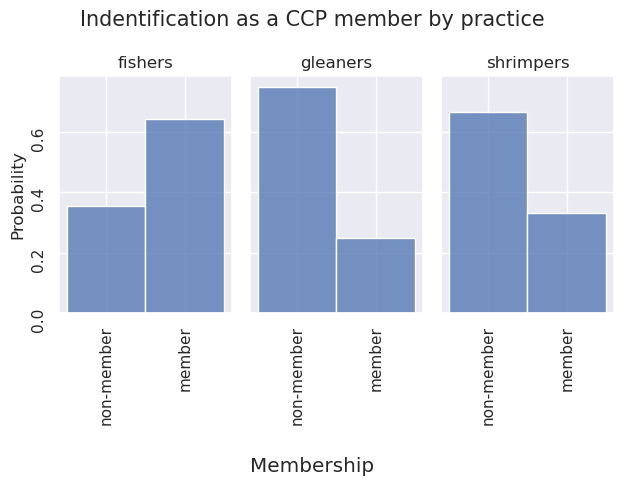

In [205]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="ccp_member", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="ccp_member", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="ccp_member", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Indentification as a CCP member by practice', fontsize=15)
fig.supxlabel('Membership')
plt.tight_layout()

### Participation in CCPs

In [206]:
# explore where data have not been entered 
nr = df_wk[df_wk['ccp_participation']=='NR']
nr 

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
24,25,20a31f8c-425a-4ab6-bb2a-c26caf0a17fb,02272023CHAC01,5/2/2023 10:00:00 AM,chamane,"01,02,03,50,56,60,78",f,35.0,community,married,...,2.0,kgs,NaN,3.0,150.0,NaN,glean,kgs,2.00,0.666667
25,26,b76b2052-2ea2-46ed-97a2-060ff2b4adb4,02272023CHAC02,5/2/2023 10:00:00 AM,chamane,"01,02,03,50,56,60,78",m,58.0,community,widowed,...,2.0,kgs,NaN,2.0,100.0,NaN,glean,kgs,2.00,1.000000
34,34,f85c025e-7064-4442-97fd-5e6c73068b59,01032023MARC03,5/3/2023 10:00:00 AM,NaN,"01,02,03,06,50,56,74,78",m,66.0,community,married,...,4.0,kgs,NaN,3.0,800.0,NaN,fish,kgs,4.00,1.333333
38,37,93ca075b-003e-4767-a9ca-b17a08ab7ed0,01032023MARC06,5/3/2023 10:00:00 AM,NaN,"01,02,03,06,50,56,74,78",f,43.0,community,married,...,10.0,cups,NaN,3.0,250.0,2.0,shrimp_net,cups,1.75,0.291667
43,41,3cbbfee3-6ad1-4a03-aa2d-10fa77270f31,02032023MUCC02,5/3/2023 10:00:00 AM,mucucune,"01,02,03,06,50,56,63,78",f,55.0,community,widowed,...,6.0,cups,NaN,3.0,180.0,2.0,shrimp_net,cups,1.05,0.175000


In [207]:
print(df_wk['ccp_participation'].unique())

['1' '0' 'NR']


Following verification of data sheets,it was determined that in all 5 surveys (02272023CHAC01, 02272023CHAC02, 01032023MARC03, 01032023MARC06, & 02032023MUCC02) responses to the question were not recorded in the field. This is likely because once they respondents said they were not members of the CCP they were not asked if they participated. This surveyer behavior was changed following the first two days of data collection.

In [208]:
df_wk.ccp_participation = pd.Categorical(df_wk.ccp_participation,categories=['0', '1', 'NR'],ordered=True)
df_wk['ccp_participation']=df_wk['ccp_participation'].map({'0': 'does not\nparticipate', '1' : 'paticipates regularly','NR': 'not recorded'})


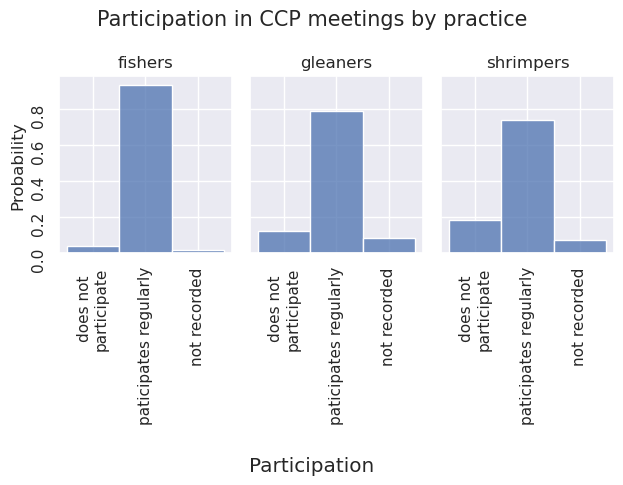

In [209]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="ccp_participation", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="ccp_participation", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="ccp_participation", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Participation in CCP meetings by practice', fontsize=15)
fig.supxlabel('Participation')
plt.tight_layout()

### Decision making - Resource Management

In [210]:
# explore where data have not been entered 
nr = df_wk[df_wk['decision_making_manag']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [211]:
print(df_wk['decision_making_manag'].unique())

[0 1]


In [212]:
df_wk.decision_making_manag = pd.Categorical(df_wk.decision_making_manag,categories=[0, 1],ordered=True)
df_wk['decision_making_manag']=df_wk['decision_making_manag'].map({0: 'not involved', 1 : 'involved'})

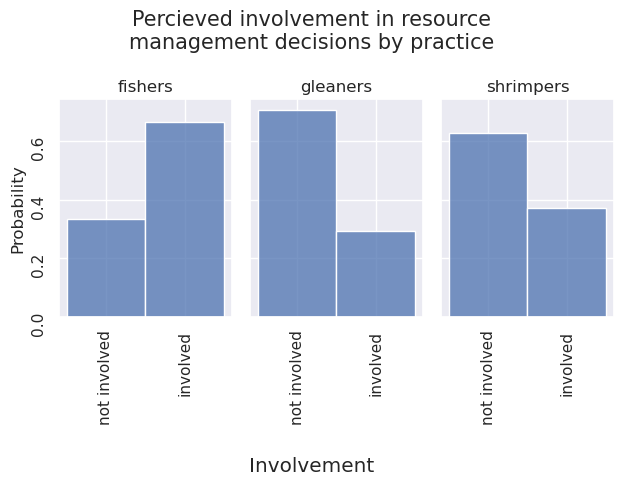

In [213]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="decision_making_manag", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="decision_making_manag", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="decision_making_manag", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved involvement in resource\nmanagement decisions by practice', fontsize=15)
fig.supxlabel('Involvement')
plt.tight_layout()

### Decision making - fishing strategy 

In [214]:
# explore where data have not been entered 
nr = df_wk[df_wk['decision_making_fish']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [215]:
df_wk['decision_making_fish']=df_wk['decision_making_fish'].map({'respondent': 'respondent', 'other' : 'another person'})

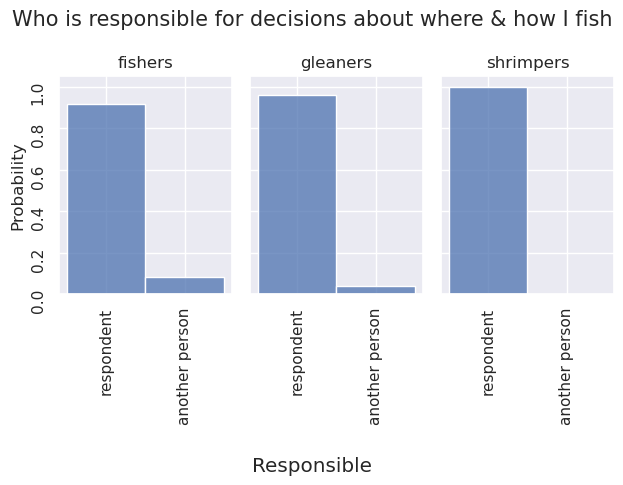

In [216]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="decision_making_fish", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="decision_making_fish", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="decision_making_fish", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Who is responsible for decisions about where & how I fish', fontsize=15)
fig.supxlabel('Responsible')
plt.tight_layout()

### Capacity to recognize change in seagrass 

In [217]:
# explore where data have not been entered 
nr = df_wk[df_wk['change_seagrass']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [218]:
df_wk['change_seagrass']=df_wk['change_seagrass'].map({'yes': 'change', 'no' : 'no change', "unsure": "not sure", 'without_time': 'less than 7\nyears fishing'})

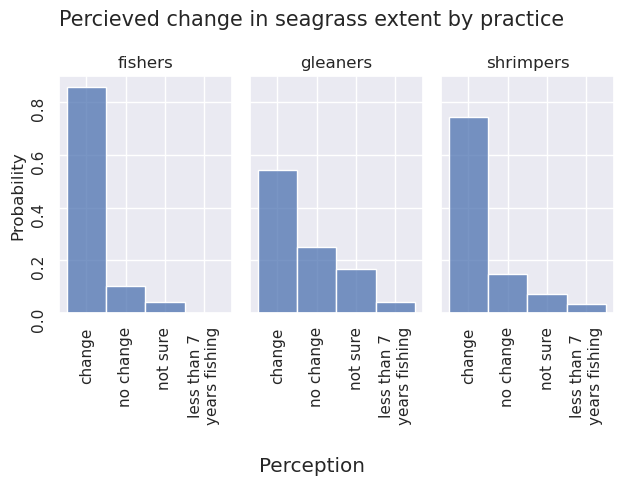

In [219]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="change_seagrass", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="change_seagrass", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="change_seagrass", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved change in seagrass extent by practice', fontsize=15)
fig.supxlabel('Perception')
plt.tight_layout()

### Capacity to recognize change in seagrass - direction

In [220]:
# explore where data have not been entered 
nr = df_wk[df_wk['direction_change_seagrass']=='NR']
nr 


,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
16,17,7d5ef953-e3a5-4712-b13a-ebc9503218f1,09032023NHCHC01,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",f,50.0,other coastal area,single,...,12.0,cups,NaN,3.5,140.0,2.0,shrimp_net,cups,2.1,0.3
21,22,16aee3b9-c62f-4b4b-9d49-1ea3aec33bfd,09032023NHCHC06,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",m,40.0,community,married,...,3.0,kgs,NaN,5.0,600.0,NaN,fish,kgs,3.0,0.6
52,50,220ca2c7-2ccc-49c1-b077-e41a34b34a54,03032023MADC02,5/4/2023 10:00:00 AM,madava,"50,52,53,56,68,70,78",f,37.0,community,married,...,1.0,basin,NaN,3.0,400.0,NaN,glean,basin,12.0,4.0


In [221]:
print(df_wk['direction_change_seagrass'].unique())

['less' 'no_change' 'sig_less' 'more' 'NR' 'unsure' 'sig_more']


After review of the data sheets, it was determined that respondent 09032023NHCHC01 & 03032023MADC02 do not have 7 years of fishing experience and thus were not asked this question. During survey 09032023NHCHC06 a response was not recorded in the field.

In [222]:

df_wk['direction_change_seagrass']=df_wk['direction_change_seagrass'].map({'sig_less': 'significantly less', 'less' : 'less','no_change': 'no change','more': 'more', 'sig_more': 'significantly more', 'unsure':'not sure', 'NR': 'not recorded'})
print(df_wk['direction_change_seagrass'].unique())
df_wk.direction_change_seagrass = pd.Categorical(df_wk.direction_change_seagrass,categories=['significantly less', 'less','no change', 'more', 'significantly more','not sure', 'not recorded'],ordered=True)
print(df_wk['direction_change_seagrass'].unique())

['less' 'no change' 'significantly less' 'more' 'not recorded' 'not sure'
 'significantly more']
['less', 'no change', 'significantly less', 'more', 'not recorded', 'not sure', 'significantly more']
Categories (7, object): ['significantly less' < 'less' < 'no change' < 'more' < 'significantly more' < 'not sure' < 'not recorded']


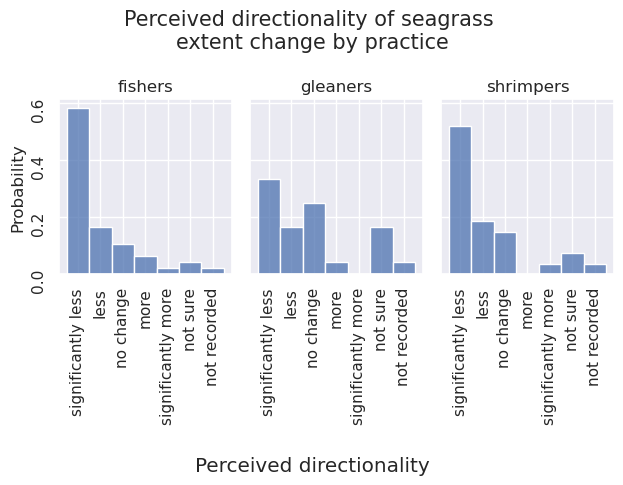

In [223]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="direction_change_seagrass", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="direction_change_seagrass", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="direction_change_seagrass", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Perceived directionality of seagrass \nextent change by practice', fontsize=15)
fig.supxlabel('Perceived directionality')
plt.tight_layout()

### Capacity to recognize causality - seagrass

In [224]:
# if repondents did not report a decrease in seagrass, they were not asked to describe why the change may have occured - this needs to be differentiate from non-responses
not_asked = ['no change','more','significantly more','not sure']

# function to reclassify the response 
def reclass(direction, causes):
    if direction in not_asked:
        return "no_decrease_perceived"
    else:
        return causes

df_wk['causes_change_seagrass']= df_wk.apply(lambda row: reclass(row['direction_change_seagrass'],row['causes_change_seagrass']), axis=1 ) 
df_wk[['id','direction_change_seagrass', 'causes_change_seagrass']] 

,id,direction_change_seagrass,causes_change_seagrass
0,05032023JOSC01,less,climate_change
1,05032023JOSC02,no change,no_decrease_perceived
2,05032023JOSC03,significantly less,destructive gear
3,05032023JOSC04,more,no_decrease_perceived
4,05032023JOSC05,no change,no_decrease_perceived
...,...,...,...
94,19022023ILHC03,significantly less,"other,climate_change"
95,19022023ILHC04,significantly less,destructive_gear
96,19022023ILHc06,less,other
97,19022023ILHC05,less,unsure


In [225]:
# explore where data have not been entered 
nr = df_wk[(df_wk['causes_change_seagrass']=='NR') & (df_wk['direction_change_seagrass'] !='NR')]
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
16,17,7d5ef953-e3a5-4712-b13a-ebc9503218f1,09032023NHCHC01,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",f,50.0,other coastal area,single,...,12.0,cups,NaN,3.5,140.0,2.0,shrimp_net,cups,2.1,0.3
21,22,16aee3b9-c62f-4b4b-9d49-1ea3aec33bfd,09032023NHCHC06,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",m,40.0,community,married,...,3.0,kgs,NaN,5.0,600.0,NaN,fish,kgs,3.0,0.6
52,50,220ca2c7-2ccc-49c1-b077-e41a34b34a54,03032023MADC02,5/4/2023 10:00:00 AM,madava,"50,52,53,56,68,70,78",f,37.0,community,married,...,1.0,basin,NaN,3.0,400.0,NaN,glean,basin,12.0,4.0


In [226]:
# examine any rows where the repsonse is other
other = df_wk[df_wk['causes_change_seagrass'].str.contains('other')]
other[['id', 'causes_change_seagrass','causes_change_seagrass_other','note']]

,id,causes_change_seagrass,causes_change_seagrass_other,note
93,1902028ILHC02,"destructive_gear,other",pastoreio dugongo,NaN
94,19022023ILHC03,"other,climate_change",sedimentação e mudanças de temperatura,NaN
96,19022023ILHc06,other,herbação de animais,NaN


In [227]:
# Reclassify responses
df_wk.loc[df_wk['id'] == '19022023ILHC03', 'causes_change_seagrass'] = 'climate_change'

In [228]:
df_wk['causes_change_seagrass'].replace('destructive gear','destructive_gear', inplace=True)
df_wk.causes_change_seagrass = df_wk.causes_change_seagrass.str.split(',')
df_exploded = df_wk.explode('causes_change_seagrass')
df_exploded.causes_change_seagrass = pd.Categorical(df_exploded.causes_change_seagrass,categories=['unsure','destructive_gear','fishing_pressure', 'climate_change', 'other', 'no_decrease_perceived', 'NR'],ordered=True)
df_exploded['causes_change_seagrass']=df_exploded['causes_change_seagrass'].map({
                                                                    'destructive_gear': 'destructive gear', 
                                                                    'fishing_pressure' : 'fishing pressure', 
                                                                    'climate_change' : 'climate change', 
                                                                    'other': 'other',
                                                                    'unsure':'unsure',
                                                                    'no_decrease_perceived':'no decrease\npercieved',
                                                                    'NR': 'not recorded'})


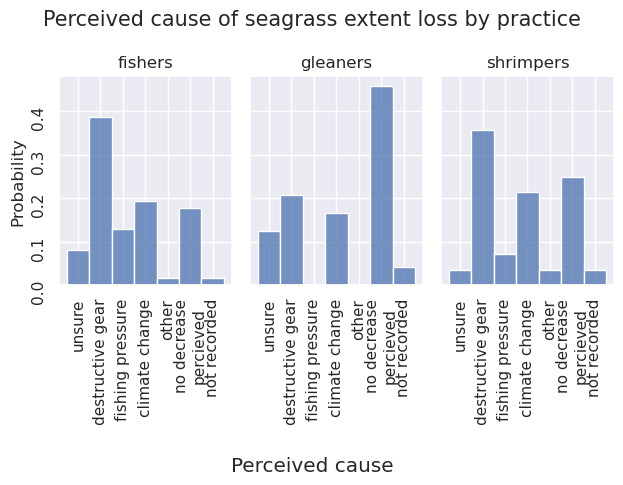

In [229]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='fish'], stat="probability", x="causes_change_seagrass", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='glean'], stat="probability", x="causes_change_seagrass", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='shrimp_net'], stat="probability", x="causes_change_seagrass", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Perceived cause of seagrass extent loss by practice', fontsize=15)
fig.supxlabel('Perceived cause')
plt.tight_layout()

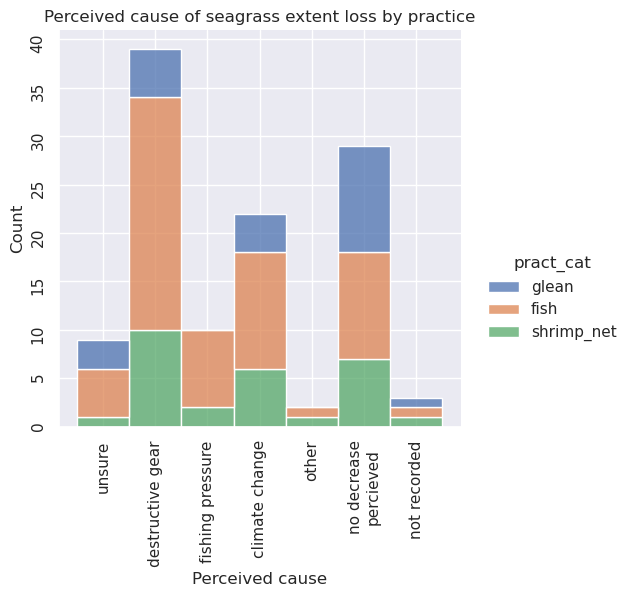

In [230]:
ax=sns.displot(df_exploded, x="causes_change_seagrass", hue="pract_cat", multiple="stack")
ax.tick_params(labelrotation=90)
ax.set(xlabel='Perceived cause', title='Perceived cause of seagrass extent loss by practice')


### Capacity to recognize change - resources

In [231]:
# explore where data have not been entered 
nr = df_wk[df_wk['change_fish']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [232]:
df_wk['change_fish']=df_wk['change_fish'].map({'yes': 'change', 'no' : 'no change', "unsure": "not sure", 'without_time': 'less than 7\nyears fishing'})

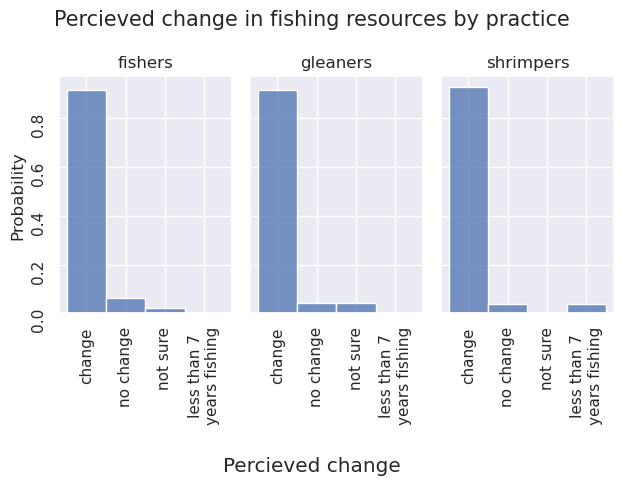

In [233]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="change_fish", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="change_fish", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="change_fish", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved change in fishing resources by practice', fontsize=15)
fig.supxlabel('Percieved change')
plt.tight_layout()

### Capacity to recognize change - resources, direction

In [234]:
nr = df_wk[df_wk['direction_change_resources']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
16,17,7d5ef953-e3a5-4712-b13a-ebc9503218f1,09032023NHCHC01,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",f,50.0,other coastal area,single,...,12.0,cups,NaN,3.5,140.0,2.0,shrimp_net,cups,2.1,0.3


The respondent in 09032023NHCHC01 does not have 7 years of fishing experience and was therefore not asked this question

In [235]:
df_wk['direction_change_resources']=df_wk['direction_change_resources'].map({'sig_less': 'significantly less', 'less' : 'less','no_change': 'no change','more': 'more', 'sig_more': 'significantly more', 'unsure':'not sure', 'NR': 'not recorded'})
print(df_wk['direction_change_resources'].unique())
df_wk.direction_change_resources = pd.Categorical(df_wk.direction_change_resources,categories=['significantly less', 'less','no change', 'more', 'significantly more','not sure', 'not recorded'],ordered=True)
print(df_wk['direction_change_resources'].unique())

['significantly less' 'less' 'no change' 'not recorded' 'more' 'not sure']
['significantly less', 'less', 'no change', 'not recorded', 'more', 'not sure']
Categories (7, object): ['significantly less' < 'less' < 'no change' < 'more' < 'significantly more' < 'not sure' < 'not recorded']


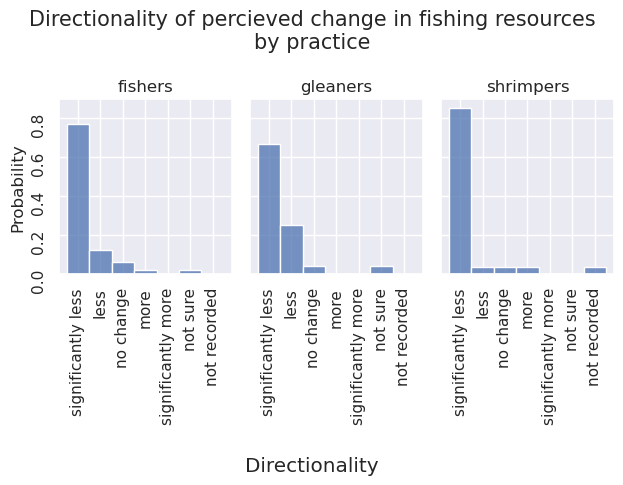

In [236]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="direction_change_resources", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="direction_change_resources", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="direction_change_resources", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Directionality of percieved change in fishing resources\nby practice', fontsize=15)
fig.supxlabel('Directionality')
plt.tight_layout()

### Capacity to recognize causality - resources

In [237]:
df_wk[['id','direction_change_resources', 'causes_change_resources']]

,id,direction_change_resources,causes_change_resources
0,05032023JOSC01,significantly less,climate_change
1,05032023JOSC02,less,unsure
2,05032023JOSC03,significantly less,fishing_pressure
3,05032023JOSC04,significantly less,destructive gear
4,05032023JOSC05,significantly less,climate_change
...,...,...,...
94,19022023ILHC03,significantly less,"fishing_pressure,other"
95,19022023ILHC04,significantly less,fishing_pressure
96,19022023ILHc06,significantly less,"destructive_gear,climate_change"
97,19022023ILHC05,less,fishing_pressure


Some respondents were not asked this question bc they did not percieve a decrease. These need to be distringuished from those where a response was not recorded


In [238]:
# reclasssify NRs based on if a change was percieved
df_wk['causes_change_resources']= df_wk.apply(lambda row: reclass(row['direction_change_resources'],row['causes_change_resources']), axis=1 ) 
df_wk[['id','direction_change_resources', 'causes_change_resources']] 

,id,direction_change_resources,causes_change_resources
0,05032023JOSC01,significantly less,climate_change
1,05032023JOSC02,less,unsure
2,05032023JOSC03,significantly less,fishing_pressure
3,05032023JOSC04,significantly less,destructive gear
4,05032023JOSC05,significantly less,climate_change
...,...,...,...
94,19022023ILHC03,significantly less,"fishing_pressure,other"
95,19022023ILHC04,significantly less,fishing_pressure
96,19022023ILHc06,significantly less,"destructive_gear,climate_change"
97,19022023ILHC05,less,fishing_pressure


In [239]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['causes_change_resources']=='NR']
nr[['id','direction_change_resources', 'causes_change_resources']]

,id,direction_change_resources,causes_change_resources
16,09032023NHCHC01,not recorded,NR


Again, 09032023NHCHC01 does not have 7 years of fishing experience and was not asked this question

In [240]:
# examine any rows where the repsonse is other
other = df_wk[df_wk['causes_change_resources'].str.contains('other')]
other[['id','direction_change_resources', 'causes_change_resources','causes_change_resources_other','note']]

,id,direction_change_resources,causes_change_resources,causes_change_resources_other,note
93,1902028ILHC02,less,"destructive_gear,other",invasão de bersarios,NaN
94,19022023ILHC03,significantly less,"fishing_pressure,other",falta de outro emprego,NaN
98,19022023ILHC07,significantly less,"destructive_gear,other",invasão de bercarios e violação dos regulament...,NaN


In [241]:
# Reclassify responses
df_wk.loc[df_wk['id'] == '1902028ILHC02', 'causes_change_resources'] = 'destructive_gear,fishing_pressure'
df_wk.loc[df_wk['id'] == '19022023ILHC03', 'causes_change_resources'] = 'fishing_pressure'
df_wk.loc[df_wk['id'] == '19022023ILHC07', 'causes_change_resources'] = 'destructive_gear,fishing_pressure'


In [242]:
# This question is select-multiple so responses are stored as a list. These entries need to be exploded so they can be put into the correct bins
df_wk['causes_change_resources'].replace('destructive gear','destructive_gear', inplace=True)
df_wk.causes_change_resources = df_wk.causes_change_resources.str.split(',')
df_exploded = df_wk.explode('causes_change_resources')
df_exploded.causes_change_resources = pd.Categorical(df_exploded.causes_change_resources,
                                                    categories=['destructive_gear',
                                                                'fishing_pressure', 'climate_change', 'unsure',
                                                                'no_decrease_perceived','NR'],ordered=True)
df_exploded['causes_change_resources']=df_exploded['causes_change_resources'].map({'unsure':'unsure',
                                                                    'destructive_gear': 'destructive gear', 
                                                                    'fishing_pressure' : 'fishing pressure', 
                                                                    'climate_change' : 'climate change', 
                                                                    'no_decrease_perceived':'no decrease percieved',
                                                                    'NR': 'not recorded'})

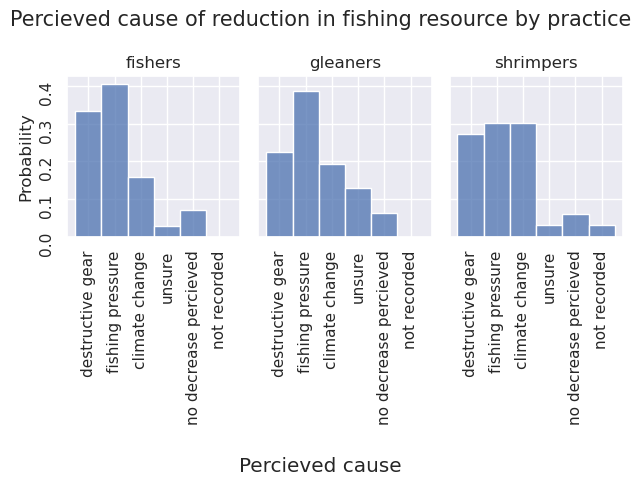

In [243]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='fish'], stat="probability", x="causes_change_resources", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='glean'], stat="probability", x="causes_change_resources", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='shrimp_net'], stat="probability", x="causes_change_resources", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved cause of reduction in fishing resource by practice', fontsize=15)
fig.supxlabel('Percieved cause')
plt.tight_layout()

### Capacity to recognize link between seagrass and resources

In [244]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['link_seagrass_resources']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
93,91,e1e019ca-77d4-4065-88fd-71858068e0d1,1902028ILHC02,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,62.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN
94,92,962e0ac8-710e-4c41-baf2-4376097ed58d,19022023ILHC03,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,53.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
95,93,05343747-e001-4123-926c-708328b8a3c2,19022023ILHC04,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,43.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
96,94,1e96f143-d7a9-4f10-b95b-4b76d6b5eb62,19022023ILHc06,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,73.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
97,95,2af6adba-79e5-43dd-a92e-0a9566b7af79,19022023ILHC05,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,50.0,community,widowed,...,NaN,NaN,NaN,NaN,NaN,NaN,glean,NaN,NaN,NaN
98,96,2cac770e-ab22-4163-85d3-80dad1b2b666,19022023ILHC07,3/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,52.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN


Note that this question was not asked in Ilha

In [245]:
df_wk.link_seagrass_resources = pd.Categorical(df_wk.link_seagrass_resources,categories=['0', '1','unsure', 'NR'],ordered=True)
df_wk['link_seagrass_resources']=df_wk['link_seagrass_resources'].map({'0':'not associated',
                                                                    '1': 'associated', 
                                                                    'unsure' : 'unsure',
                                                                    'NR': 'not recorded'})

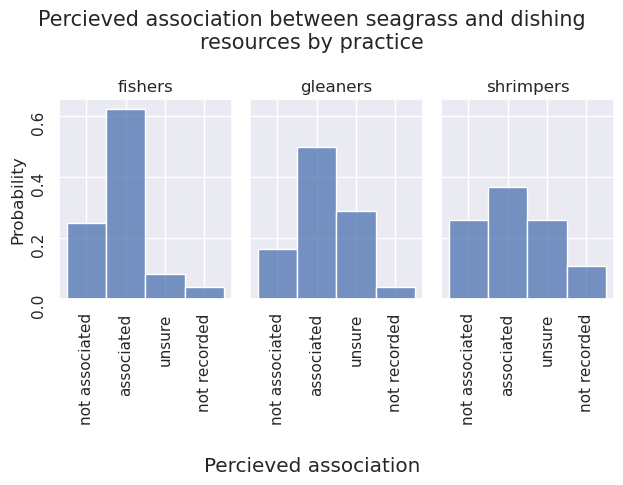

In [246]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="link_seagrass_resources", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="link_seagrass_resources", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="link_seagrass_resources", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved association between seagrass and dishing\nresources by practice', fontsize=15)
fig.supxlabel('Percieved association')
plt.tight_layout()

### Capcity to change fishing practice

In [247]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['capacity_change_practice']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [248]:
df_wk['capacity_change_practice']=df_wk['capacity_change_practice'].map({'disagree_strong':'disagree strongly',
                                                                    'disagree_weak': 'disagree slightly', 
                                                                    'neutral' : 'neutral',
                                                                    'agree_weak': 'agree slightly',
                                                                    'agree_strong': 'agree strongly'})
df_wk.capacity_change_practice = pd.Categorical(df_wk.capacity_change_practice,categories=['disagree strongly', 'disagree slightly', 'neutral','agree slightly','agree strongly'],ordered=True)

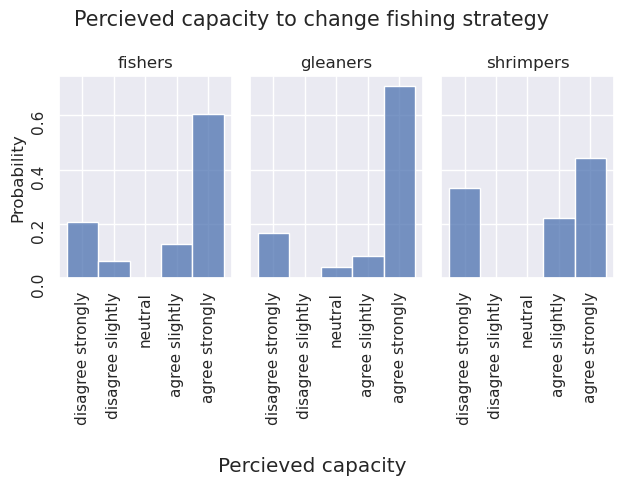

In [249]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="capacity_change_practice", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="capacity_change_practice", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="capacity_change_practice", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved capacity to change fishing strategy', fontsize=15)
fig.supxlabel('Percieved capacity')
plt.tight_layout()

### Capacity to change livelihood

In [250]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['capacity_change_livelihood']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [251]:
df_wk['capacity_change_livelihood']=df_wk['capacity_change_livelihood'].map({'disagree_strong':'disagree strongly',
                                                                    'disagree_weak': 'disagree slightly', 
                                                                    'neutral' : 'neutral',
                                                                    'agree_weak': 'agree slightly',
                                                                    'agree_strong': 'agree strongly'})
df_wk.capacity_change_livelihood = pd.Categorical(df_wk.capacity_change_livelihood,categories=['disagree strongly', 'disagree slightly', 'neutral','agree slightly','agree strongly'],ordered=True)

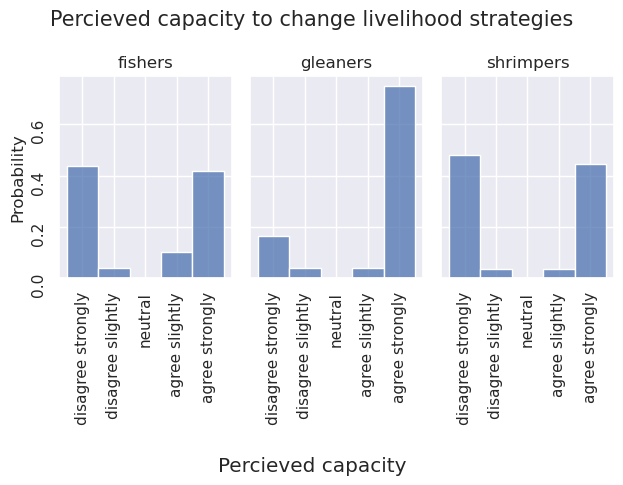

In [252]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="capacity_change_livelihood", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="capacity_change_livelihood", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="capacity_change_livelihood", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved capacity to change livelihood strategies', fontsize=15)
fig.supxlabel('Percieved capacity')
plt.tight_layout()

### Capcity to organize

In [253]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['capacity_organize']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [254]:
df_wk['capacity_organize']=df_wk['capacity_organize'].map({'disagree_strong':'disagree strongly',
                                                                    'disagree_weak': 'disagree slightly', 
                                                                    'neutral' : 'neutral',
                                                                    'agree_weak': 'agree slightly',
                                                                    'agree_strong': 'agree strongly'})
df_wk.capacity_organize = pd.Categorical(df_wk.capacity_organize,categories=['disagree strongly', 'disagree slightly', 'neutral','agree slightly','agree strongly'],ordered=True)

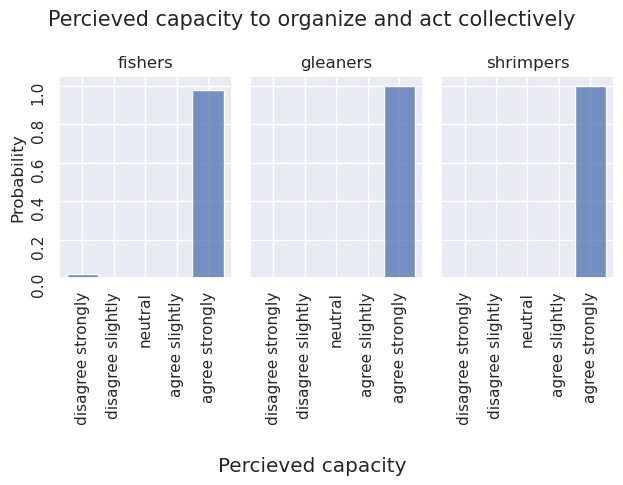

In [255]:


fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="capacity_organize", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="capacity_organize", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="capacity_organize", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Percieved capacity to organize and act collectively', fontsize=15)
fig.supxlabel('Percieved capacity')
plt.tight_layout()

### Local knowledge

In [256]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['local_knowledge']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [257]:
df_wk['local_knowledge']=df_wk['local_knowledge'].map({'disagree_strong':'disagree strongly',
                                                                    'disagree_weak': 'disagree slightly', 
                                                                    'neutral' : 'neutral',
                                                                    'agree_weak': 'agree slightly',
                                                                    'agree_strong': 'agree strongly'})
df_wk.local_knowledge = pd.Categorical(df_wk.local_knowledge,categories=['disagree strongly', 'disagree slightly', 'neutral','agree slightly','agree strongly'],ordered=True)

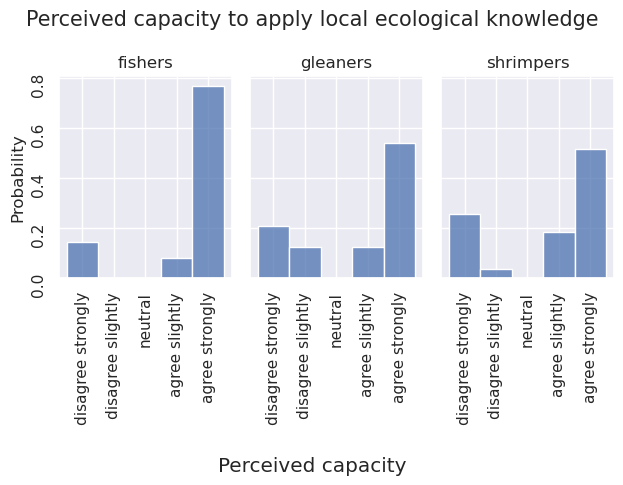

In [258]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="local_knowledge", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="local_knowledge", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="local_knowledge", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Perceived capacity to apply local ecological knowledge', fontsize=15)
fig.supxlabel('Perceived capacity')
plt.tight_layout()

### Agenecy to change - loss of seagrass

In [259]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['agency_change_seagrass']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [260]:
print(df_wk['agency_change_seagrass'].unique())

['no_change' 'fish_less' 'leave' 'other' 'fish_less,change_gear'
 'change_area']


In [261]:
other = df_wk[df_wk['agency_change_seagrass'].str.contains('other')]
other[['id','agency_change_seagrass','agency_change_seagrass_other', 'note']]

,id,agency_change_seagrass,agency_change_seagrass_other,note
48,02032023MUCC07,other,Reunir_se com colegas para tomar decisoes,...
58,03032023MADC08,other,Nao tem ideia,...
79,08032023MORC04,other,faz apanha de um outro produto,22a. plantio de mangal. ...
91,04032023NGUC08,other,"Parar um determinado tempo, ficar sem pescar.",JR ; the capture was reorded using a unit of l...


In [262]:
# Reclassify responses
df_wk.loc[df_wk['id'] == '03032023MADC08', 'agency_change_seagrass'] = 'no_change'
df_wk.loc[df_wk['id'] == '08032023MORC04', 'agency_change_seagrass'] = 'change_gear'
df_wk.loc[df_wk['id'] == '04032023NGUC08', 'agency_change_seagrass'] = 'leave'

In [263]:
df_wk.agency_change_seagrass = df_wk.agency_change_seagrass.str.split(',')
df_exploded = df_wk.explode('agency_change_seagrass')
df_exploded['agency_change_seagrass']=df_exploded['agency_change_seagrass'].map({'leave': 'leave', 
                                                    'fish_less': 'fish less',
                                                    'change_area': 'change fishing area', 
                                                    'change_gear' : 'change gear or\ntarget species',
                                                    'no_change':'no change',
                                                    'other': 'other'})
df_exploded.agency_change_seagrass = pd.Categorical(df_exploded.agency_change_seagrass,categories=['leave', 'fish less',  'change fishing area', 'change gear or\ntarget species', 'no change', 'other'],ordered=True)

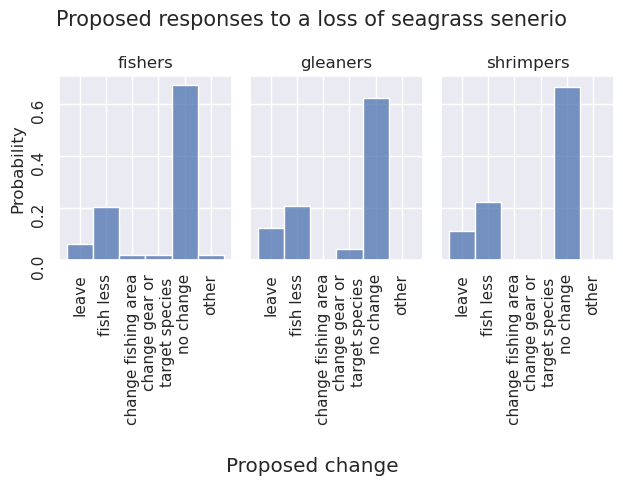

In [264]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='fish'], stat="probability", x="agency_change_seagrass", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='glean'], stat="probability", x="agency_change_seagrass", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='shrimp_net'], stat="probability", x="agency_change_seagrass", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Proposed responses to a loss of seagrass senerio', fontsize=15)
fig.supxlabel('Proposed change')
plt.tight_layout()

### Agency to change - resources

In [265]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['agency_change_capture']=='NR']
nr

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue


In [266]:
other = df_wk[df_wk['agency_change_capture'].str.contains('other')]
other[['id','agency_change_capture','agency_change_capture_other', 'note']]

,id,agency_change_capture,agency_change_capture_other,note
42,02032023MUCC01,other,Pescar menos sem fazer outro meio de subsistencia,13b. O pescador salientou que a quantidade das...
46,02032023MUCC05,other,Vai poupar no grupo de poupanca,...
48,02032023MUCC07,other,Reunir_se com colegas para a veda,...


In [267]:
# Reclassify responses
df_wk.loc[df_wk['id'] == '02032023MUCC01', 'agency_change_capture'] = 'fish_less'

In [268]:
df_wk.agency_change_capture = df_wk.agency_change_capture.str.split(',')
df_exploded = df_wk.explode('agency_change_capture')
df_exploded['agency_change_capture']=df_exploded['agency_change_capture'].map({'leave': 'leave', 
                                                    'fish_less': 'fish less',
                                                    'change_area': 'change fishing area', 
                                                    'change_gear' : 'change gear or\ntarget species',
                                                    'no_change':'no change',
                                                    'other': 'other'})
df_exploded.agency_change_capture = pd.Categorical(df_exploded.agency_change_capture,categories=['leave', 'fish less',  'change fishing area', 'change gear or\ntarget species', 'no change', 'other'],ordered=True)

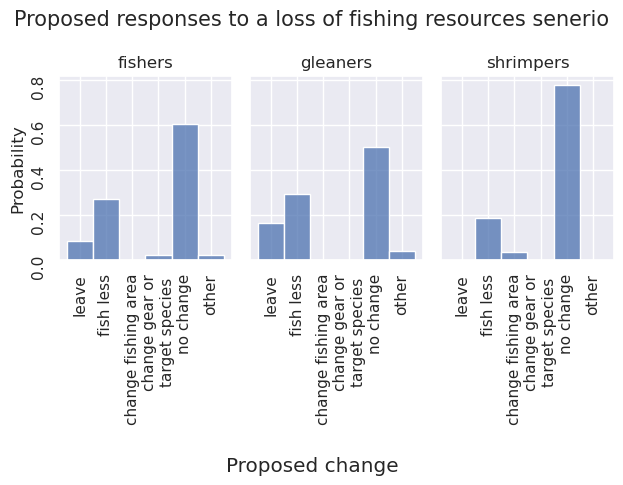

In [269]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='fish'], stat="probability", x="agency_change_capture", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='glean'], stat="probability", x="agency_change_capture", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='shrimp_net'], stat="probability", x="agency_change_capture", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Proposed responses to a loss of fishing resources senerio', fontsize=15)
fig.supxlabel('Proposed change')
plt.tight_layout()

### Knowledge of seagrass management 

In [270]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['action_seagrass']=='NR']
nr
# note this question was not asked at Ilha

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
92,90,c98b22ed-337c-4c47-b427-1e748a4ed6c4,18022023ILHC01,2/18/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,20.0,community,single,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
93,91,e1e019ca-77d4-4065-88fd-71858068e0d1,1902028ILHC02,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,62.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN
94,92,962e0ac8-710e-4c41-baf2-4376097ed58d,19022023ILHC03,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,53.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
95,93,05343747-e001-4123-926c-708328b8a3c2,19022023ILHC04,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,43.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
96,94,1e96f143-d7a9-4f10-b95b-4b76d6b5eb62,19022023ILHc06,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,73.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
97,95,2af6adba-79e5-43dd-a92e-0a9566b7af79,19022023ILHC05,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,50.0,community,widowed,...,NaN,NaN,NaN,NaN,NaN,NaN,glean,NaN,NaN,NaN
98,96,2cac770e-ab22-4163-85d3-80dad1b2b666,19022023ILHC07,3/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,52.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN


In [271]:
# explore any rows where the response was not recorded
other = df_wk[df_wk['action_seagrass'].str.contains('other')]
other[['id','action_seagrass', 'action_seagrass_other','note']]


,id,action_seagrass,action_seagrass_other,note
12,07032023NHMUC05,other,chuva,"22a. outra, chuva."


In [272]:
# Reclassify responses
df_wk.loc[df_wk['id'] == '07032023NHMUC05', 'agency_change_capture'] = 'not sure'

In [273]:
print(df_wk['action_seagrass'].unique())

['unsure' 'change_gear' 'fishing_manag' 'reduce_fishing,change_gear'
 'reduce_fishing,change_gear,fishing_manag' 'other' 'reduce_fishing'
 'reduce_fishing,plant' 'change_gear,fishing_manag'
 'reduce_fishing,fishing_manag' 'plant' 'change_gear,fishing_manag,plant'
 'NR']


In [274]:
df_wk.action_seagrass = df_wk.action_seagrass.str.split(',')
df_exploded = df_wk.explode('action_seagrass')
print(df_exploded['action_seagrass'].unique())
df_exploded['action_seagrass']=df_exploded['action_seagrass'].map({'plant': 'plant seagrass', 
                                                    'reduce_fishing': 'reduce fishing\npressure',
                                                    'fishing_manag': 'fisheries\nmanangement measures', 
                                                    'change_gear' : 'change gear\ntypes used',
                                                    'other': 'other',
                                                    'unsure':'not sure',
                                                    'NR': 'not recorded'})
df_exploded.action_seagrass = pd.Categorical(df_exploded.action_seagrass,categories=['plant seagrass', 'reduce fishing\npressure', 'fisheries\nmanangement measures','change gear\ntypes used', 'other', 'not sure', 'not recorded'],ordered=True)

['unsure' 'change_gear' 'fishing_manag' 'reduce_fishing' 'other' 'plant'
 'NR']


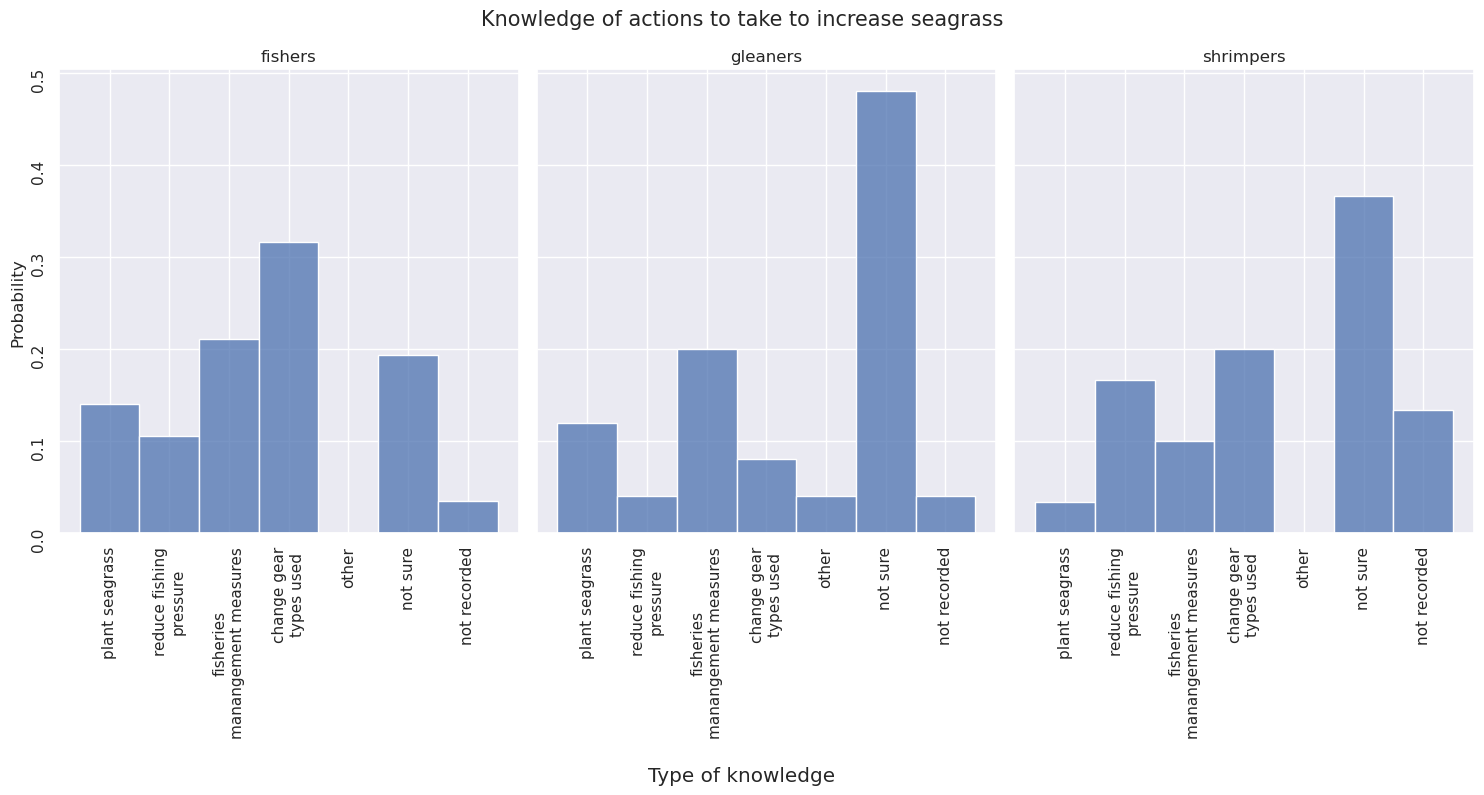

In [275]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='fish'], stat="probability", x="action_seagrass", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='glean'], stat="probability", x="action_seagrass", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='shrimp_net'], stat="probability", x="action_seagrass", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Knowledge of actions to take to increase seagrass', fontsize=15)
fig.supxlabel('Type of knowledge')

fig.set_size_inches(15, 8)
plt.tight_layout()

### Knowldge of human management seagrass

In [276]:
# function to reclassify the response 
def reclass(action, human_manag):
    if 'unsure' in action:
        return '0'
    else:
        return human_manag
    

df_wk['human_mang_seagrass'] = df_wk.apply(lambda row: reclass(row['action_seagrass'], row['human_mang_seagrass']), axis=1)
df_wk[['action_seagrass','human_mang_seagrass']]

,action_seagrass,human_mang_seagrass
0,[unsure],0
1,[unsure],0
2,[change_gear],1
3,[unsure],0
4,[fishing_manag],1
...,...,...
94,[NR],NR
95,[NR],NR
96,[NR],NR
97,[NR],NR


In [277]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['human_mang_seagrass']=='NR']
nr
# note this question was not asked at Ilha

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
92,90,c98b22ed-337c-4c47-b427-1e748a4ed6c4,18022023ILHC01,2/18/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,20.0,community,single,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
93,91,e1e019ca-77d4-4065-88fd-71858068e0d1,1902028ILHC02,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,62.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN
94,92,962e0ac8-710e-4c41-baf2-4376097ed58d,19022023ILHC03,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,53.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
95,93,05343747-e001-4123-926c-708328b8a3c2,19022023ILHC04,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,43.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
96,94,1e96f143-d7a9-4f10-b95b-4b76d6b5eb62,19022023ILHc06,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,73.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
97,95,2af6adba-79e5-43dd-a92e-0a9566b7af79,19022023ILHC05,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,50.0,community,widowed,...,NaN,NaN,NaN,NaN,NaN,NaN,glean,NaN,NaN,NaN
98,96,2cac770e-ab22-4163-85d3-80dad1b2b666,19022023ILHC07,3/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,52.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN


In [278]:
df_wk.human_mang_seagrass = pd.Categorical(df_wk.human_mang_seagrass,categories=['0', '1', 'NR'],ordered=True)
df_wk['human_mang_seagrass']=df_wk['human_mang_seagrass'].map({'0':'no',
                                                                    '1': 'yes', 
                                                                    'NR': 'not recorded'})

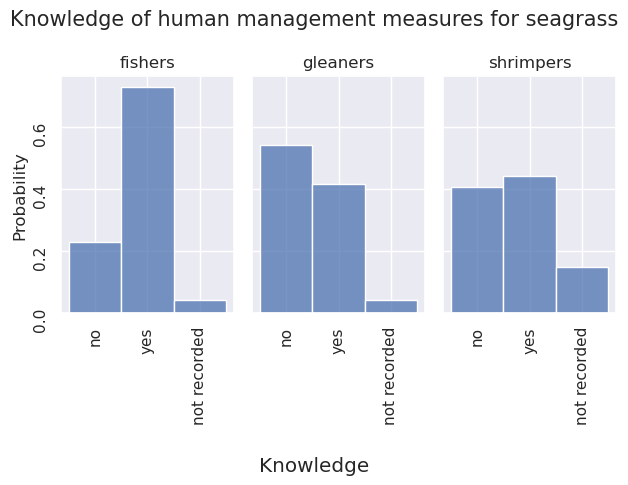

In [279]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="human_mang_seagrass", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="human_mang_seagrass", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="human_mang_seagrass", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Knowledge of human management measures for seagrass', fontsize=15)
fig.supxlabel('Knowledge')
plt.tight_layout()

### Knowledge of resource management

In [280]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['action_capture']=='NR']
nr
# note this question was not asked at Ilha

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
58,56,a656481f-be46-4f2a-b83d-28a3e3af1f01,03032023MADC08,5/4/2023 10:00:00 AM,madava,"50,52,53,56,68,70,78",m,NaN,community,single,...,20.0,kgs,NaN,5.0,4000.0,2.0,fish,kgs,20.0,2.0
92,90,c98b22ed-337c-4c47-b427-1e748a4ed6c4,18022023ILHC01,2/18/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,20.0,community,single,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
93,91,e1e019ca-77d4-4065-88fd-71858068e0d1,1902028ILHC02,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,62.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN
94,92,962e0ac8-710e-4c41-baf2-4376097ed58d,19022023ILHC03,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,53.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
95,93,05343747-e001-4123-926c-708328b8a3c2,19022023ILHC04,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,43.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
96,94,1e96f143-d7a9-4f10-b95b-4b76d6b5eb62,19022023ILHc06,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,73.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
97,95,2af6adba-79e5-43dd-a92e-0a9566b7af79,19022023ILHC05,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,50.0,community,widowed,...,NaN,NaN,NaN,NaN,NaN,NaN,glean,NaN,NaN,NaN
98,96,2cac770e-ab22-4163-85d3-80dad1b2b666,19022023ILHC07,3/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,52.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN


In [281]:
# explore any rows where the response was not recorded
other = df_wk[df_wk['action_capture'].str.contains('other')]
other[['id', 'action_capture', 'note']]

print(df_wk['action_capture'].unique())

['fishing_manag' 'reduce_fishing' 'unsure' 'reduce_fishing,change_gear'
 'reduce_fishing,change_gear,fishing_manag' 'change_gear'
 'change_gear,fishing_manag' 'fishing_manag,reduce_fishing'
 'NR,fishing_manag' 'reduce_fishing,fishing_manag' 'NR']


In [282]:

df_wk.action_capture = df_wk.action_capture.str.split(',')
df_exploded = df_wk.explode('action_capture')
df_exploded['action_capture']=df_exploded['action_capture'].map({ 
                                                    'reduce_fishing': 'reduce fishing\npressure',
                                                    'fishing_manag': 'fisheries\nmanangement measures', 
                                                    'change_gear' : 'change gear\ntypes used',
                                                    'unsure':'not sure',
                                                    'NR': 'not recorded'})
df_exploded.action_capture = pd.Categorical(df_exploded.action_capture,categories=['reduce fishing\npressure', 'fisheries\nmanangement measures', 'change gear\ntypes used', 'not sure','not recorded'],ordered=True)

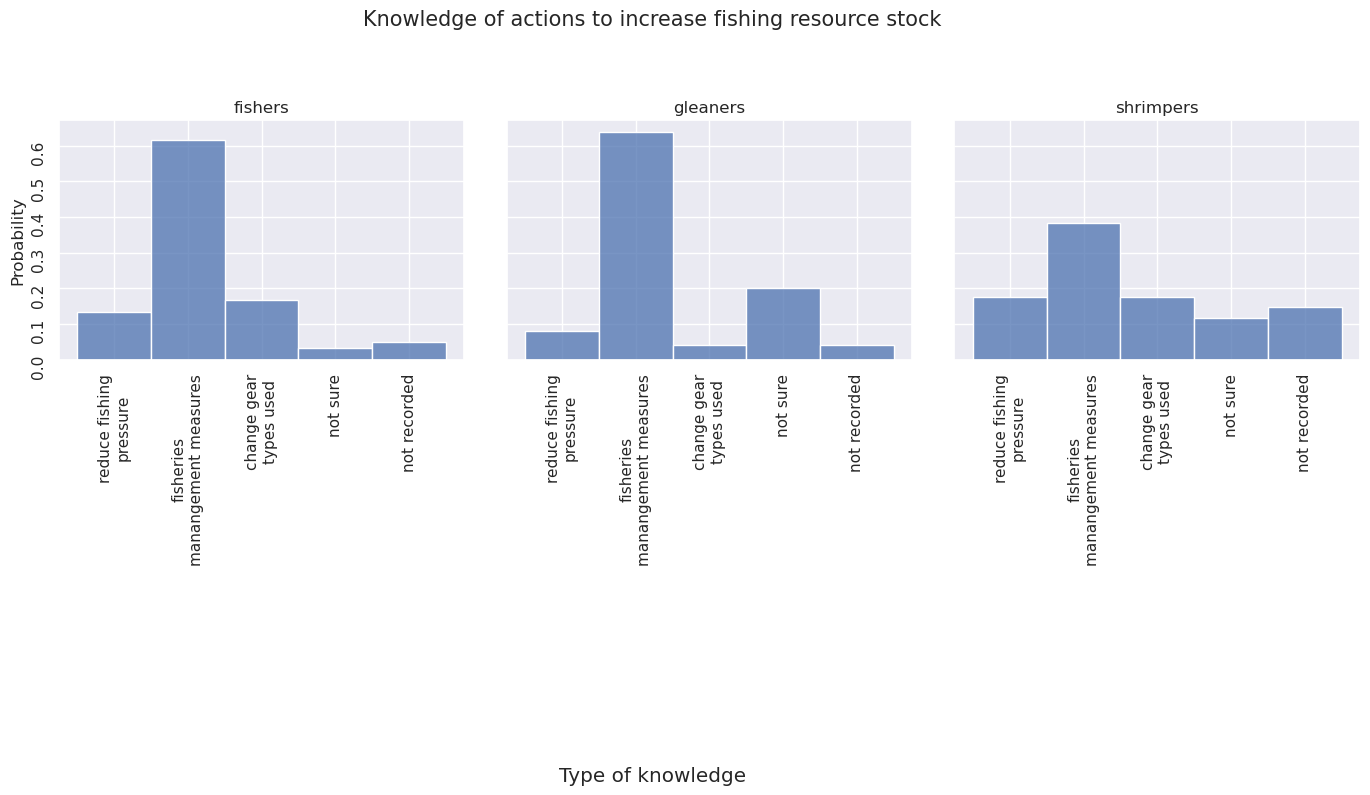

In [283]:

fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='fish'], stat="probability", x="action_capture", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='glean'], stat="probability", x="action_capture", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_exploded[df_exploded['pract_cat']=='shrimp_net'], stat="probability", x="action_capture", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Knowledge of actions to increase fishing resource stock', fontsize=15)
fig.supxlabel('Type of knowledge')
plt.tight_layout()
    
fig.set_size_inches(15, 8)

### Knowledge of human management fishing resources

In [284]:
df_wk['human_mang_capture'] = df_wk.apply(lambda row: reclass(row['action_capture'], row['human_mang_capture']), axis=1)

In [285]:
# explore any rows where the response was not recorded
nr = df_wk[df_wk['human_mang_capture']=='NR']
nr
# Note that this question was not asked on the Ilha

,objectid,ParentGlobalID,id,date,ccp,focal_resources,gender,age,birth_place,mar_status,...,quantity,unit,units_other,hours,value,persons,pract_cat,unit_final,cap_daily_total,cpue
20,21,8f4f17d7-465d-49dd-be16-fe75270b1ebf,09032023NHCHC05,5/2/2023 10:00:00 AM,nhamaxaxa,"01,02,03,11,50,56,63,71",m,62.0,community,single,...,1.0,basin,NaN,5.0,2000.0,3.0,fish,basin,12.0,0.8
92,90,c98b22ed-337c-4c47-b427-1e748a4ed6c4,18022023ILHC01,2/18/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,20.0,community,single,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
93,91,e1e019ca-77d4-4065-88fd-71858068e0d1,1902028ILHC02,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,62.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN
94,92,962e0ac8-710e-4c41-baf2-4376097ed58d,19022023ILHC03,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,53.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
95,93,05343747-e001-4123-926c-708328b8a3c2,19022023ILHC04,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,43.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
96,94,1e96f143-d7a9-4f10-b95b-4b76d6b5eb62,19022023ILHc06,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,73.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,shrimp_net,NaN,NaN,NaN
97,95,2af6adba-79e5-43dd-a92e-0a9566b7af79,19022023ILHC05,2/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",f,50.0,community,widowed,...,NaN,NaN,NaN,NaN,NaN,NaN,glean,NaN,NaN,NaN
98,96,2cac770e-ab22-4163-85d3-80dad1b2b666,19022023ILHC07,3/19/2023 10:00:00 AM,ilha,"01,03,37,50,56,60,61",m,52.0,community,married,...,NaN,NaN,NaN,NaN,NaN,NaN,fish,NaN,NaN,NaN


In [286]:
df_wk.human_mang_capture = pd.Categorical(df_wk.human_mang_capture,categories=['0', '1', 'NR'],ordered=True)
df_wk['human_mang_capture']=df_wk['human_mang_capture'].map({'0':'no',
                                                                    '1': 'yes', 
                                                                    'NR': 'not recorded'})

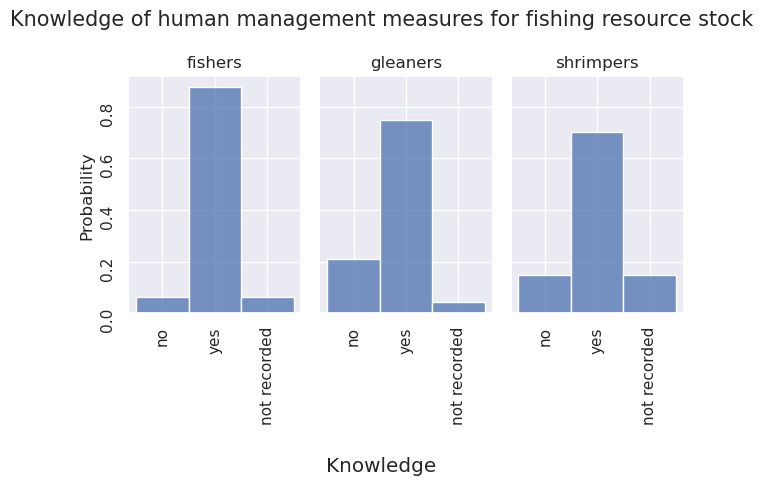

In [287]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex= True)
g1=sns.histplot(data=df_wk[df_wk['pract_cat']=='fish'], stat="probability", x="human_mang_capture", ax=axes[0])
axes[0].set_title('fishers')
g1.set(xlabel=None)
g2=sns.histplot(data=df_wk[df_wk['pract_cat']=='glean'], stat="probability", x="human_mang_capture", ax=axes[1])
axes[1].set_title('gleaners')
g2.set(xlabel=None)
g3=sns.histplot(data=df_wk[df_wk['pract_cat']=='shrimp_net'], stat="probability", x="human_mang_capture", ax=axes[2])
axes[2].set_title('shrimpers')
g3.set(xlabel=None)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)

fig.suptitle('Knowledge of human management measures for fishing resource stock', fontsize=15)
fig.supxlabel('Knowledge')
plt.tight_layout()

In [288]:
df_wk[['id', 'date', 'ccp',
       'gender', 'age', 'birth_place', 'mar_status', 'ed_level', 'house_head',
       'glean', 'electricity', 'fridge_freezer', 'fridge_freezer_num', 'water',
       'matress', 'matress_num', 'mobile_phone', 'mobile_phone_num',
       'smart_phone', 'smart_phone_num', 'fan', 'fan_num', 'tv', 'tv_num',
       'radio', 'radio_num', 'stove', 'stove_num', 'transport',
       'transport_num', 'floor', 'floor_other', 'wall', 'wall_other', 'roof',
       'roof_other', 'access_credit_loans', 'community_participation',
       'ccp_member', 'ccp_participation', 'decision_making_manag',
       'decision_making_fish', 'change_seagrass', 'direction_change_seagrass',
       'causes_change_seagrass', 'change_fish', 'direction_change_resources',
       'causes_change_resources', 'link_seagrass_resources',
       'capacity_change_practice', 'capacity_change_livelihood',
       'capacity_organize', 'local_knowledge', 'agency_change_seagrass',
       'agency_change_seagrass_other', 'agency_change_capture',
       'agency_change_capture_other', 'action_seagrass',
       'action_seagrass_other', 'human_mang_seagrass', 'action_capture',
       'action_capture_other', 'human_mang_capture', 'gear', 'hours','cap_daily_total',
       'value', 'persons', 'pract_cat',
       'cpue']].to_csv("../adaptive_cap_clean.csv")